# Data Science Fundamentals Project

A short story of how we came to NO2 as our target variable:

Fredi: If somebody had asked me half a year ago, whether I could build a predictive model, I would've said: No!
Nino: I would've said No, too.
Fredi: "NO2", let's try and predict it!



Welcome to our data science project focused on predicting NO2 concentrations. We are using advanced analytics and machine learning to forecast NO2 levels based on a range of features, from meteorological conditions to human activities.

In [24]:
# Load all of the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


## Datasets
For our prediction, the following datasets are necessary:

- 1: Täglich aktualisierte Luftqualitätsmessungen, seit 1983
   - https://data.stadt-zuerich.ch/dataset/ugz_luftschadstoffmessung_tageswerte
- 2: Daten der Verkerzählung zum motorisierten Individualverkehr (Stundenwerte), seit 2012
   - https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031
- 3: Täglich aktualisierte Meteodaten, seit 1992
   - https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_tagesmittelwerte
- 4: Stündlich aktualisierte Meteodaten, seit 1992
   - https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte
- 5: Baumkataster
   - https://data.stadt-zuerich.ch/dataset/geo_baumkataster


We decided to make predictions on a daily basis, as to not be too granular with our prediction.

## Preprocessing
The first step was to merge all of the datasets to be able to predict NO2 well with the other columns. 

### Functions used for Preprocessing
- We created the function "import_and_transform_air_quality_data()" to loop over all of the years from 2012 to 2023 and merge all of the datasets while only taking the following streets into consideration: "Rosengartenstrasse", "Stampfenbachstrasse" and "Schimmelstrasse". These are the only three streets, for which data in all sets exist.

In [25]:
def import_and_transform_air_quality_data():
    streets = ['Zch_Rosengartenstrasse', 'Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse']
    street_dataframes = []

    for street in streets:
        yearly_data = []

        for year in range(2012, 2024):
            file_path = f'data/air/ugz_ogd_air_d1_{year}.csv'
            data = pd.read_csv(file_path)

            # Filter for a specific street
            street_data = data[data['Standort'] == street]

            # Pivot the data
            street_wide = street_data.pivot(index='Datum', columns='Parameter', values='Wert')

            # Add the year and street columns
            street_wide['Year'] = year
            street_wide['Street'] = street

            yearly_data.append(street_wide)

        # Concatenate all years' data for the street
        combined_street_data = pd.concat(yearly_data)
        street_dataframes.append(combined_street_data)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes)

    return combined_data


In [26]:
airquality = import_and_transform_air_quality_data()

- Another function we created is "import_and_transform_traffic_data()", which handles the preprocessing for datset 2 in a similar fashion as the function above. In addition, it sums up the hourly values to daily values

In [27]:
def import_and_transform_traffic_data():
    streets = ['Stampfenbachstrasse (Wasserwerkstrasse)', 'Schimmelstrasse (Werdstrasse)', 'Rosengartenstrasse']
    street_dataframes = []

    for street in streets:
        yearly_data = []

        for year in range(2012, 2024):
            file_path = f'data/traffic/sid_dav_verkehrszaehlung_miv_OD2031_{year}.csv'
            traffic = pd.read_csv(file_path, low_memory=False)


            # Drop unnecessary columns and filter for a specific street
            traffic_small = traffic.drop(columns=['MSID', 'MSName', 'Hoehe', 'EKoord', 'NKoord', 'AnzDetektoren', 'D1ID', 'D2ID', 'D3ID','D4ID', 'Knummer', 'ZSID'])
            traffic_rg = traffic_small[traffic_small['ZSName'] == street].copy()

            # Convert 'MessungDatZeit' column to datetime
            try:
                traffic_rg['MessungDatZeit'] = pd.to_datetime(traffic_rg['MessungDatZeit'])
            except pd.errors.OutOfBoundsDatetime:
                # Handle conversion errors, for example, if the data contains unexpected values
                print(f"Error converting 'MessungDatZeit' column for year {year} and street {street}")

            # Aggregate data
            daily_traffic = traffic_rg.groupby(traffic_rg['MessungDatZeit'].dt.date)['AnzFahrzeuge'].sum().reset_index(name='TotalDailyTraffic')
            daily_traffic['Year'] = year
            daily_traffic['Street'] = street

            yearly_data.append(daily_traffic)

        # Concatenate all years' data for the street
        combined_street_data = pd.concat(yearly_data)
        street_dataframes.append(combined_street_data)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes)

    return combined_data

In [28]:
traffic = import_and_transform_traffic_data()

Now, we have two big datasets with all of the relevant data from years 2012 to 2023. To be able to merge them we do the steps in the cell below.

In [29]:
#Introduce an Index for both df
airquality = airquality.reset_index()
traffic = traffic.reset_index()
# Convert the 'Datum' column in air quality data to datetime and extract the date
airquality['Datum'] = pd.to_datetime(airquality['Datum']).dt.date

# Replace street names in traffic data to match the air quality data
traffic.replace(['Stampfenbachstrasse (Wasserwerkstrasse)', 'Schimmelstrasse (Werdstrasse)', 'Rosengartenstrasse'],
                ['Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse', 'Zch_Rosengartenstrasse'], inplace=True)

# Rename the 'MessungDatZeit' column in traffic data to 'Datum'
traffic.rename(columns={'MessungDatZeit': 'Datum'}, inplace=True)

#### Merging of the two datasets

In [30]:
merged_df = pd.merge(traffic, airquality, how="left", on=['Datum', 'Street'])
merged_df.drop(columns=['Year_x', 'Year_y'], inplace=True)

### Additional Features: Meteo Data
Now that we have many of the necessary features inside of one dataset, we want to add some more that could make our prediction model more accurate. For that we turned to meteo data, which is dataset 3.






In [31]:
def import_and_transform_meteo_data():
    streets = ['Zch_Rosengartenstrasse', 'Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse']
    street_dataframes = []

    for street in streets:
        yearly_data = []

        for year in range(2012, 2024):
            file_path = f'data/meteo/daily/ugz_ogd_meteo_d1_{year}.csv'
            data = pd.read_csv(file_path)

            # Filter for a specific street
            street_data = data[data['Standort'] == street]

            # Pivot the data and reset the index
            street_wide = street_data.pivot(index='Datum', columns='Parameter', values='Wert').reset_index()

            # Add the year and street columns
            street_wide['Year'] = year
            street_wide['Street'] = street

            yearly_data.append(street_wide)

        # Concatenate all years' data for the street
        combined_street_data = pd.concat(yearly_data)
        street_dataframes.append(combined_street_data)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes)

    return combined_data


In [32]:
meteo = import_and_transform_meteo_data()
meteo['Datum'] = pd.to_datetime(meteo['Datum']).dt.date
meteo.head()

Parameter       Datum  Year                  Street  RainDur   T  T_max_h1  \
0          2013-10-04  2013  Zch_Rosengartenstrasse   191.77 NaN       NaN   
1          2013-10-05  2013  Zch_Rosengartenstrasse    84.13 NaN       NaN   
2          2013-10-06  2013  Zch_Rosengartenstrasse   147.52 NaN       NaN   
3          2013-10-07  2013  Zch_Rosengartenstrasse     0.00 NaN       NaN   
4          2013-10-08  2013  Zch_Rosengartenstrasse     0.00 NaN       NaN   

Parameter       p  StrGlo  
0          969.68     NaN  
1          968.27     NaN  
2          973.08     NaN  
3          973.86     NaN  
4          973.71     NaN

The cell below merges the merged dataframe from above and the meteo dataframe.

In [33]:
# Merge DataFrames
merged_meteo = pd.merge(merged_df, meteo, how="left", on=['Datum', 'Street'])

merged_meteo.head()

index       Datum  TotalDailyTraffic                   Street    NO    NO2  \
0      0  2012-01-01             8118.0  Zch_Stampfenbachstrasse  7.83  26.54   
1      1  2012-01-02             7537.0  Zch_Stampfenbachstrasse  3.51  17.87   
2      2  2012-01-03            11722.0  Zch_Stampfenbachstrasse  5.85  19.62   
3      3  2012-01-04            12161.0  Zch_Stampfenbachstrasse  2.59  13.25   
4      4  2012-01-05            12310.0  Zch_Stampfenbachstrasse  2.23  10.11   

     NOx     O3  O3_max_h1  O3_nb_h1>120  ...  PM2.5    CO   SO2  PN    Year  \
0  20.16  22.24      43.46           0.0  ...    NaN  0.31  1.78 NaN  2012.0   
1  12.16  36.06      53.56           0.0  ...    NaN  0.24  1.64 NaN  2012.0   
2  14.95  48.88      66.05           0.0  ...    NaN  0.24  1.40 NaN  2012.0   
3   9.00  59.47      67.55           0.0  ...    NaN  0.22  1.11 NaN  2012.0   
4   7.08  62.58      71.45           0.0  ...    NaN  0.20  0.90 NaN  2012.0   

   RainDur     T  T_max_h1       p  StrGlo  
0    95.60  8.12      9.60  968.64   39.61  
1   397.10  6.96     10.67  965.34   12.59  
2    71.47  6.29      9.15  972.62   63.38  
3   400.90  6.07      8.22  970.64   43.04  
4   748.32  5.02      6.84  957.33   11.24  

[5 rows x 21 columns]

Data on windspeed and humidity is only found in the hourly meteo set, so we will sum it up to daily values and merge it with the rest of the data. 

In [34]:
def import_and_transform_meteo_hourly_data():
    streets = ['Zch_Rosengartenstrasse', 'Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse']
    street_dataframes = []
    parameters = ['WD', 'WVv', 'WVs', 'Hr']

    for year in range(2012, 2024): 
        for street in streets:
            file_path = f'data/meteo/hourly/ugz_ogd_meteo_h1_{year}.csv'  
            data = pd.read_csv(file_path)

            # Filter for a specific street
            street_data = data[data['Standort'] == street]

            # Pivot the data to wide format
            street_wide = street_data.pivot(index='Datum', columns='Parameter', values='Wert')

            # Reset index to make 'Datum' a column again
            street_wide.reset_index(inplace=True)

            # Convert 'Datum' to datetime and keep only the date part
            street_wide['Datum'] = pd.to_datetime(street_wide['Datum']).dt.date

            # Select only the columns that exist in the dataset
            cols_to_keep = ['Datum'] + [col for col in parameters if col in street_wide.columns]
            street_wide = street_wide[cols_to_keep]

            # Group by Datum, calculate daily mean
            daily_mean = street_wide.groupby('Datum', as_index=False).mean()

            # Add the street name to the DataFrame
            daily_mean['Street'] = street

            street_dataframes.append(daily_mean)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes, ignore_index=True)

    return combined_data

# Use this function and export the result if needed
meteo_hourly = import_and_transform_meteo_hourly_data()
#merge it

merged_meteo = pd.merge(merged_meteo, meteo_hourly, how="left", on=['Datum', 'Street'])

### Additional Features: Dummies

Dummies enable the model to consider seasonal and weekday variations, potentially improving predictions by capturing temporal patterns in the target variable.


In [35]:
# Convert 'Datum' to datetime
merged_meteo['Datum'] = pd.to_datetime(merged_meteo['Datum'])

# Drop unnecessary columns
merged_meteo.drop(columns=['Year'], inplace=True)

#Adding season dummies
merged_meteo['Season'] = (merged_meteo['Datum'].dt.month % 12 + 3) // 3
season_dummies = pd.get_dummies(merged_meteo['Season'], prefix='Season')
merged_meteo = pd.concat([merged_meteo, season_dummies], axis=1).drop(columns=['Season'])

# Adding weekday dummies
merged_meteo['Weekday'] = merged_meteo['Datum'].dt.dayofweek
weekday_dummies = pd.get_dummies(merged_meteo['Weekday'], prefix='Weekday')
merged_meteo = pd.concat([merged_meteo, weekday_dummies], axis=1)
merged_meteo.drop(['Weekday'], axis=1, inplace=True)

### Additional Features: Relevant Street Specific Data

As we want to generalize our model to be applicable to other streets, we tried to find data which is relevant for the specific street.

The only data we found was geodata on trees and greenspaces. We also thought about taking the speed limits, however these are all the same for the three streets (Fredi went to check personally).

We used the coordinates from the geodata to calculate the number trees/greenspaces around our measurement points.

In [36]:
#Calculating trees around measurement points

tree_locations_df = pd.read_csv('data/street/gsz.baumkataster_baumstandorte.csv')

#Function to extract the coordinates
def extract_coordinates(point_str):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", point_str)
    return tuple(map(float, numbers))

tree_locations_df['coordinates'] = tree_locations_df['geometry'].apply(extract_coordinates)

#Function to calculate the distance between to coordinastes
def calculate_distance(coord1, coord2):
    return ((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2) ** 0.5

#Coordinates of our measurement points
target_coords = {
    "Zch_Rosengartenstrasse": (2682095, 1249940),
    "Zch_Schimmelstrasse": (2681950, 1247250),
    "Zch_Stampfenbachstrasse": (2683140, 1249040)
}

tree_counts_df = pd.DataFrame(columns=['Street', '1.5km', '1km', '500m', '200m'])

#Calculating the number of trees within different radii
for street, coords in target_coords.items():
    tree_counts = {
        'Street': street,
        '1.5km': sum(calculate_distance(tree_coord, coords) <= 1500 for tree_coord in tree_locations_df['coordinates']),
        '1km': sum(calculate_distance(tree_coord, coords) <= 1000 for tree_coord in tree_locations_df['coordinates']),
        '500m': sum(calculate_distance(tree_coord, coords) <= 500 for tree_coord in tree_locations_df['coordinates']),
        '200m': sum(calculate_distance(tree_coord, coords) <= 200 for tree_coord in tree_locations_df['coordinates'])
    }
    tree_counts_df = pd.concat([tree_counts_df, pd.DataFrame([tree_counts])], ignore_index=True)


#Calculating green spaces around measurement points

green_spaces_df = pd.read_csv('data/street/gsz.gruenflaechen.csv')

#Extracting the coordinates
green_spaces_df['coordinates'] = green_spaces_df['geometry'].apply(extract_coordinates)

green_space_counts_df = pd.DataFrame(columns=['Street', '1.5km', '1km', '500m', '200m'])

#Calculating the number of green spaces within different radii
for street, coords in target_coords.items():
    green_space_counts = {
        'Street': street,
        '1.5km': sum(calculate_distance(green_coord, coords) <= 1500 for green_coord in green_spaces_df['coordinates']),
        '1km': sum(calculate_distance(green_coord, coords) <= 1000 for green_coord in green_spaces_df['coordinates']),
        '500m': sum(calculate_distance(green_coord, coords) <= 500 for green_coord in green_spaces_df['coordinates']),
        '200m': sum(calculate_distance(green_coord, coords) <= 200 for green_coord in green_spaces_df['coordinates'])
    }
    green_space_counts_df = pd.concat([green_space_counts_df, pd.DataFrame([green_space_counts])], ignore_index=True)


In [37]:
#Merging it with our big dataset

merged_meteo = pd.merge(merged_meteo, green_space_counts_df, on='Street', how='left', suffixes=('_green', ''))
merged_meteo = pd.merge(merged_meteo, tree_counts_df, on='Street', how='left', suffixes=('','_trees'))
distance_columns_to_rename = {
    '1.5km': '1.5km_green',
    '1km': '1km_green',
    '500m': '500m_green',
    '200m': '200m_green'
}
merged_meteo = merged_meteo.rename(columns=distance_columns_to_rename)
merged_meteo.columns

Index(['index', 'Datum', 'TotalDailyTraffic', 'Street', 'NO', 'NO2', 'NOx',
       'O3', 'O3_max_h1', 'O3_nb_h1>120', 'PM10', 'PM2.5', 'CO', 'SO2', 'PN',
       'RainDur', 'T', 'T_max_h1', 'p', 'StrGlo', 'WD', 'WVv', 'WVs', 'Hr',
       'Season_1', 'Season_2', 'Season_3', 'Season_4', 'Weekday_0',
       'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', '1.5km_green', '1km_green', '500m_green', '200m_green',
       '1.5km_trees', '1km_trees', '500m_trees', '200m_trees'],
      dtype='object')

### Target Variable NO2_tomorrow

For our model we want to predict future values. Thus, our target variable is the NO2 value of tomorrow. For this we shift up the NO2 column by one row, which allows us to use past information to predict the next day's NO2 level. We do this for each street seperately and then merge them together again.

In [38]:
# Create the NO2_tomorrow (target variable) column by shifting the NO2 column up by one row
unique_streets = merged_meteo['Street'].unique()
data_separated = []
for street in unique_streets:
    df_street = merged_meteo[merged_meteo['Street'] == street].copy()
    df_street['NO2_tomorrow'] = df_street['NO2'].shift(-1)
    data_separated.append(df_street)

merged_meteo = pd.concat(data_separated)

merged_meteo.head()

index      Datum  TotalDailyTraffic                   Street    NO    NO2  \
0      0 2012-01-01             8118.0  Zch_Stampfenbachstrasse  7.83  26.54   
1      1 2012-01-02             7537.0  Zch_Stampfenbachstrasse  3.51  17.87   
2      2 2012-01-03            11722.0  Zch_Stampfenbachstrasse  5.85  19.62   
3      3 2012-01-04            12161.0  Zch_Stampfenbachstrasse  2.59  13.25   
4      4 2012-01-05            12310.0  Zch_Stampfenbachstrasse  2.23  10.11   

     NOx     O3  O3_max_h1  O3_nb_h1>120  ...  Weekday_6  1.5km_green  \
0  20.16  22.24      43.46           0.0  ...       True         7471   
1  12.16  36.06      53.56           0.0  ...      False         7471   
2  14.95  48.88      66.05           0.0  ...      False         7471   
3   9.00  59.47      67.55           0.0  ...      False         7471   
4   7.08  62.58      71.45           0.0  ...      False         7471   

   1km_green  500m_green  200m_green  1.5km_trees  1km_trees  500m_trees  \
0       4473        1611         132         9115       4054        1419   
1       4473        1611         132         9115       4054        1419   
2       4473        1611         132         9115       4054        1419   
3       4473        1611         132         9115       4054        1419   
4       4473        1611         132         9115       4054        1419   

   200m_trees  NO2_tomorrow  
0         152         17.87  
1         152         19.62  
2         152         13.25  
3         152         10.11  
4         152         17.67  

[5 rows x 44 columns]

### Addressing Seasonality in the Data

While we've incorporated dummy variables for both season and weekday, it's worth considering the impact of seasonality on our observations. Let's explore the dataset to better understand the presence of seasonality and assess whether its removal could enhance our analysis.

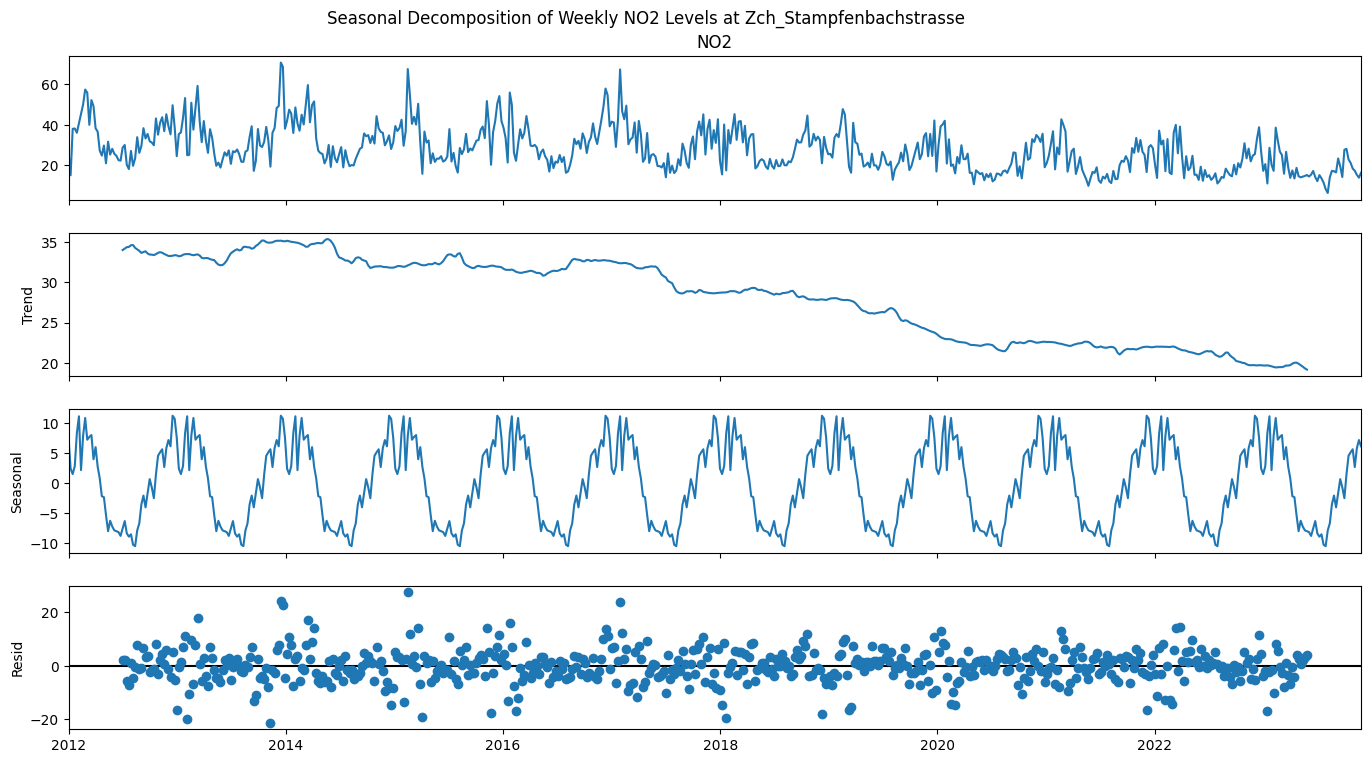

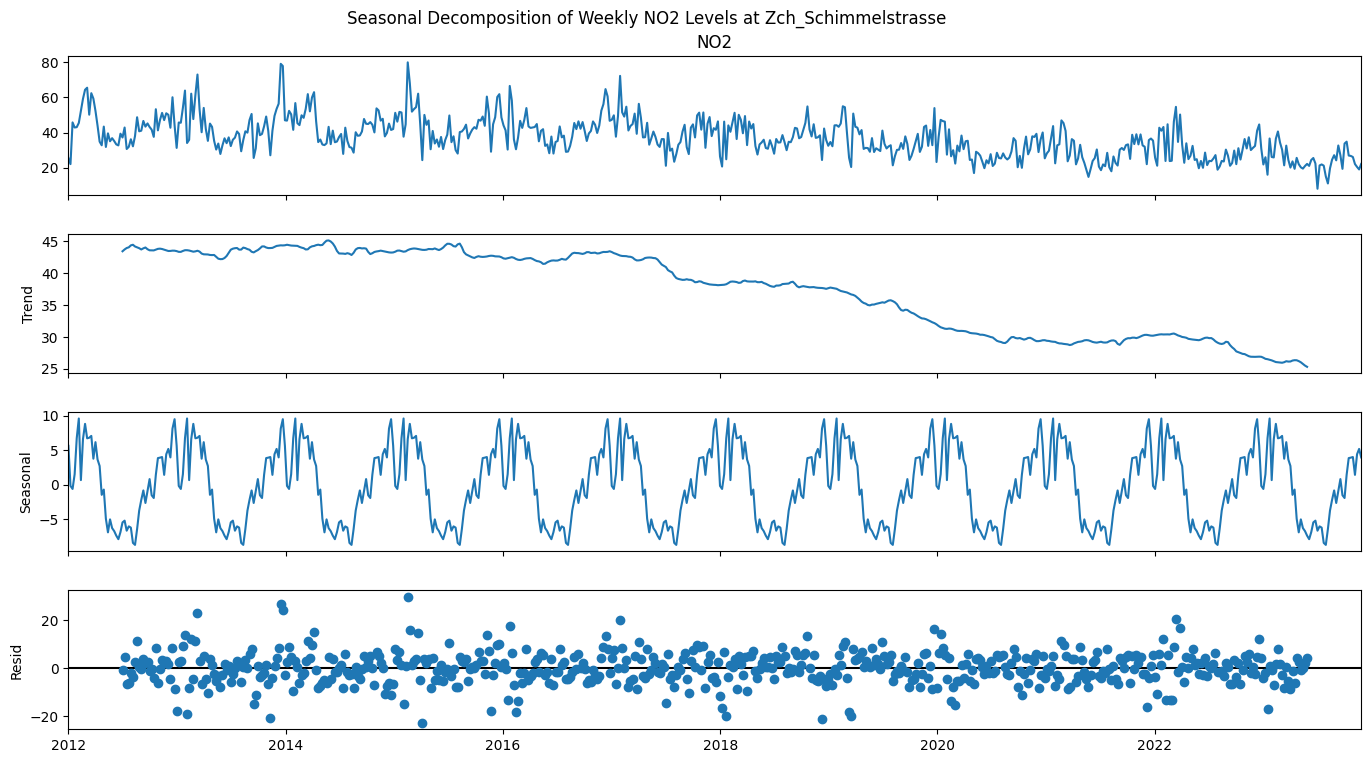

In [39]:
unique_streets = merged_meteo['Street'].unique()

# Iterating through each street and performing seasonal decomposition
for street in unique_streets:
    # Filtering data for the current street
    street_data = merged_meteo[merged_meteo['Street'] == street]

    # Aggregating NO2 levels to weekly average
    street_data.set_index('Datum', inplace=True)
    weekly_street_data = street_data['NO2'].resample('W').mean()

    # Perform seasonal decomposition if there are enough data points
    if not weekly_street_data.isnull().all():
        decomposition = seasonal_decompose(weekly_street_data.dropna(), model='additive', period=52)

        # Plotting the decomposed components of the time series
        fig = decomposition.plot()
        fig.set_size_inches(15, 8)
        plt.suptitle(f'Seasonal Decomposition of Weekly NO2 Levels at {street}')
        plt.show()
    else:
        print(f"No NO2 values are available for {street} in the dataset.")


In our analysis, we have observed pronounced seasonality across all three streets in the dataset. Notably, the incorporation of NO2 as a feature, with a time lag of only one day (`NO2_tomorrow`), inherently captures the observed seasonality. The temporal dependencies in NO2, including both short-term fluctuations and seasonal patterns, are implicitly accounted for in our model.

Additionally, we have identified a discernible downward trend in our target variable. This trend is also integrated into our NO2 feature through its time-lagged representation. By leveraging the sequential nature of time series data, our model is designed to not only capture seasonality but also naturally incorporate trends, providing a comprehensive representation of historical patterns.

These considerations affirm our approach to feature engineering and the effectiveness of our model in accounting for both short-term and long-term temporal dynamics in NO2 levels.


### Splitting our Dataset

We will split our dataset into three smaller sets:

1. Training set: This one will be used to train our model
2. Validation set: This one will be used to check our model's performance and tune hyperparameters
3. Test set: This one will be applied only at the very end, representing completely unseen data. Thus, this allows us to get a real life evaluation of our model.

As we have seen above, temporal considerations such as seasonality do play a role in our model. Hence, we thought that, in order to capture all these effects, we will not split our dataset randomly. Rather, we will split it based on years. 

- 2012 to 2019: Training
- 2020 and 2021: Validation
- 2022 and 2023: Test

In [40]:
# Drop the redundant index column
merged_meteo.drop(columns=['index'], inplace=True)

In [41]:
# Filtering the dataset for the test set (years 2022 and 2023)
test_set = merged_meteo[(merged_meteo['Datum'].dt.year == 2022) | (merged_meteo['Datum'].dt.year == 2023)]

# Filtering the dataset for the validation set (years 2019, 2020, and 2021)
validation_set = merged_meteo[(merged_meteo['Datum'].dt.year >= 2020) & (merged_meteo['Datum'].dt.year <= 2021)]

# Filtering the dataset for the training set (years 2012 to 2018)
train_set = merged_meteo[(merged_meteo['Datum'].dt.year >= 2012) & (merged_meteo['Datum'].dt.year <= 2019)]

### Handling Missing Data

Our approach is as follows: 

- Target variable: Here we will not do any imputations. We believe it makes more sense to just drop it, as this is the variable we want to predict with our model
- Features: We will plot the features and see how they are distributed. If they show a lot of outliers, we will impute by median, as it is more robust to outliers. Otherwise, we will impute simply with the mean. 

Thereby, we will avoid future leaks by imouting only with the mean/median calculated on the train set.


In [42]:
# Checking for missing values in the target variable 'NO2_tomorrow'

missing_values_target = train_set['NO2_tomorrow'].isnull().sum() #revealed around 700 missing values, we will delete these rows
train_set = train_set.dropna(subset=['NO2_tomorrow'])
test_set = test_set.dropna(subset=['NO2_tomorrow'])
validation_set = validation_set.dropna(subset=['NO2_tomorrow'])

In [43]:
# Checking for columns with a high percentage of missing values

missing_values = train_set.isnull().sum()
missing_values_percentage = (missing_values / len(train_set)) * 100

#columns with more than 50% missing values
columns_high_missing_values = missing_values_percentage[missing_values_percentage > 50].sort_values(ascending=False)

columns_high_missing_values

PM2.5     64.952404
SO2       64.025219
StrGlo    63.963407
CO        63.926320
PN        53.986896
dtype: float64

While it seems tempting to just drop these columns, we will keept them for now. We do not want to loose potential valuable data. 

In [45]:
# Count NaNs for all columns
missing_count_per_column = train_set.isna().sum()

# Filter columns with missing values
columns_with_missing_values = missing_count_per_column[missing_count_per_column > 0]

# Display the count of missing values for columns with missing values
print(columns_with_missing_values)


NO                14
NO2               14
NOx               14
O3                66
O3_max_h1         70
O3_nb_h1>120      70
PM10             219
PM2.5           5254
CO              5171
SO2             5179
PN              4367
RainDur           15
T                 31
T_max_h1          34
p                 17
StrGlo          5174
WD               598
WVv              598
WVs             4021
Hr                11
dtype: int64


We observe that there are a total of 20 columns that contain missing values.
We plot a histogram and boxplot of each of the 20 columns to observe the distribution of the data.

In [46]:
columns_with_missing_values = [
    "NO", "NO2", "NOx", "O3", "O3_max_h1", "O3_nb_h1>120", "PM10",
    "RainDur", "T", "T_max_h1", "p", "WD", "WVv", 'WVs', "Hr", 'SO2', 'StrGlo', 'CO', 'PN', 'PM2.5'
]

fig, axes = plt.subplots(nrows=len(columns_with_missing_values), ncols=2, figsize=(15, 4 * len(columns_with_missing_values)))

for i, column_name in enumerate(columns_with_missing_values):
    # Select the right axes for boxplot and histogram
    ax_box = axes[i, 0]
    ax_hist = axes[i, 1]

    # Drop NaN values from the column
    column_data = train_set[column_name].dropna()

    # Boxplot
    ax_box.boxplot(column_data)
    ax_box.set_title(f'Boxplot of {column_name}')
    ax_box.set_xticks([])

    # Histogram
    bin_count = 30  # Increased number of bins for more detail
    ax_hist.hist(column_data, bins=bin_count, edgecolor='black', alpha=0.7, density=True)
    ax_hist.set_title(f'Histogram of {column_name}')

    # Calculate and plot the mean
    mean = column_data.mean()
    ax_hist.axvline(mean, color='red', linestyle='dashed', linewidth=2)
    ax_hist.text(mean, ax_hist.get_ylim()[1] * 0.9, f'Mean: {mean:.2f}', color='red')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

For rows with a lot of NaN's, regular imputation might not make sense (we would have a lot of similar rows then). Let's find these

In [47]:
# Finding rows with multiple NaN values
rows_with_multiple_nans_train = train_set[train_set.isna().sum(axis=1) > 10]
rows_with_multiple_nans_test = test_set[test_set.isna().sum(axis=1) > 10]
rows_with_multiple_nans_validation = validation_set[validation_set.isna().sum(axis=1) > 10]


# Identifying the names of features missing in rows with multiple NaNs
missing_features_train = rows_with_multiple_nans_train.isna().apply(lambda x: list(x[x].index), axis=1)
missing_features_train_df = missing_features_train.to_frame(name="Missing Features")
missing_features_test = rows_with_multiple_nans_test.isna().apply(lambda x: list(x[x].index), axis=1)
missing_features_test_df = missing_features_test.to_frame(name="Missing Features")
missing_features_validation = rows_with_multiple_nans_validation.isna().apply(lambda x: list(x[x].index), axis=1)
missing_features_validation_df = missing_features_validation.to_frame(name="Missing Features")

In [48]:
row_indices_train = missing_features_train.index
row_indices_test = missing_features_test.index
row_indices_validation = missing_features_validation.index
selected_rows_train = train_set.loc[row_indices_train]
selected_rows_test = test_set.loc[row_indices_test]
selected_rows_validation = validation_set.loc[row_indices_validation]

selected_rows_train

Datum  TotalDailyTraffic                   Street     NO    NO2  \
1824  2016-12-29                0.0  Zch_Stampfenbachstrasse    NaN    NaN   
4821  2013-04-23            28271.0      Zch_Schimmelstrasse    NaN    NaN   
5587  2015-05-29            27654.0      Zch_Schimmelstrasse    NaN    NaN   
5724  2015-10-13            27565.0      Zch_Schimmelstrasse    NaN    NaN   
5725  2015-10-14            22276.0      Zch_Schimmelstrasse  38.61  42.74   
6636  2018-04-12            30103.0      Zch_Schimmelstrasse    NaN    NaN   
7254  2019-12-21            27330.0      Zch_Schimmelstrasse    NaN    NaN   
9327  2013-10-03            24281.0   Zch_Rosengartenstrasse    NaN    NaN   
9328  2013-10-04            24544.0   Zch_Rosengartenstrasse  99.35  39.00   
9329  2013-10-05            20893.0   Zch_Rosengartenstrasse  41.38  34.32   
9330  2013-10-06            17409.0   Zch_Rosengartenstrasse  21.16  29.13   
9331  2013-10-07            22520.0   Zch_Rosengartenstrasse  50.96  35.23   
9332  2013-10-08            23181.0   Zch_Rosengartenstrasse  50.94  36.84   
9639  2014-08-11            20351.0   Zch_Rosengartenstrasse  32.36  38.56   
9640  2014-08-12            21049.0   Zch_Rosengartenstrasse  42.16  47.80   
9641  2014-08-13            21076.0   Zch_Rosengartenstrasse  32.74  37.27   
9962  2015-06-30                0.0   Zch_Rosengartenstrasse    NaN    NaN   
10217 2016-03-11            26543.0   Zch_Rosengartenstrasse    NaN    NaN   
10358 2016-07-30            16131.0   Zch_Rosengartenstrasse    NaN    NaN   
11189 2018-11-08            27149.0   Zch_Rosengartenstrasse    NaN    NaN   

          NOx     O3  O3_max_h1  O3_nb_h1>120   PM10  ...  Weekday_6  \
1824      NaN    NaN        NaN           NaN    NaN  ...      False   
4821      NaN    NaN        NaN           NaN    NaN  ...      False   
5587      NaN    NaN        NaN           NaN    NaN  ...      False   
5724      NaN    NaN        NaN           NaN    NaN  ...      False   
5725    53.31    NaN        NaN           NaN  25.95  ...      False   
6636      NaN    NaN        NaN           NaN    NaN  ...      False   
7254      NaN    NaN        NaN           NaN    NaN  ...      False   
9327      NaN    NaN        NaN           NaN    NaN  ...      False   
9328   100.05   3.53       7.29           0.0  24.97  ...      False   
9329    51.12  28.38      57.44           0.0  11.29  ...      False   
9330    32.20  31.23      40.60           0.0    NaN  ...       True   
9331    59.28  14.84      33.11           0.0    NaN  ...      False   
9332    60.10   6.90      14.70           0.0  33.83  ...      False   
9639    46.11    NaN        NaN           NaN  13.37  ...      False   
9640    58.80    NaN        NaN           NaN  15.57  ...      False   
9641    45.74    NaN        NaN           NaN    NaN  ...      False   
9962      NaN    NaN        NaN           NaN    NaN  ...      False   
10217     NaN    NaN        NaN           NaN    NaN  ...      False   
10358     NaN    NaN        NaN           NaN    NaN  ...      False   
11189     NaN    NaN        NaN           NaN    NaN  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
1824          7471       4473        1611         132         9115       4054   
4821          8273       3779         901         140        10143       4389   
5587          8273       3779         901         140        10143       4389   
5724          8273       3779         901         140        10143       4389   
5725          8273       3779         901         140        10143       4389   
6636          8273       3779         901         140        10143       4389   
7254          8273       3779         901         140        10143       4389   
9327          8289       3424        1271         219         9730       3376   
9328          8289       3424        1271         219         9730       3376   
9329          8289       3424        1271        

In [49]:
selected_rows_test

Datum  TotalDailyTraffic                  Street     NO    NO2  \
8400  2023-02-13            33108.0     Zch_Schimmelstrasse    NaN    NaN   
8537  2023-06-30            32896.0     Zch_Schimmelstrasse    NaN    NaN   
8587  2023-08-19            40371.0     Zch_Schimmelstrasse    NaN    NaN   
8654  2023-10-25            34270.0     Zch_Schimmelstrasse    NaN    NaN   
12606 2022-09-27            27706.0  Zch_Rosengartenstrasse    NaN    NaN   
12684 2022-12-14            26581.0  Zch_Rosengartenstrasse    NaN    NaN   
12947 2023-09-05            25028.0  Zch_Rosengartenstrasse  13.64  31.22   
12991 2023-10-19            23449.0  Zch_Rosengartenstrasse    NaN    NaN   

         NOx  O3  O3_max_h1  O3_nb_h1>120  PM10  ...  Weekday_6  1.5km_green  \
8400     NaN NaN        NaN           NaN   NaN  ...      False         8273   
8537     NaN NaN        NaN           NaN   NaN  ...      False         8273   
8587     NaN NaN        NaN           NaN   NaN  ...      False         8273   
8654     NaN NaN        NaN           NaN   NaN  ...      False         8273   
12606    NaN NaN        NaN           NaN   NaN  ...      False         8289   
12684    NaN NaN        NaN           NaN   NaN  ...      False         8289   
12947  27.26 NaN        NaN           NaN   NaN  ...      False         8289   
12991    NaN NaN        NaN           NaN   NaN  ...      False         8289   

       1km_green  500m_green  200m_green  1.5km_trees  1km_trees  500m_trees  \
8400        3779         901         140        10143       4389        1138   
8537        3779         901         140        10143       4389        1138   
8587        3779         901         140        10143       4389        1138   
8654        3779         901         140        10143       4389        1138   
12606       3424        1271         219         9730       3376         918   
12684       3424        1271         219         9730       3376         918   
12947       3424        1271         219         9730       3376         918   
12991       3424        1271         219         9730       3376         918   

       200m_trees  NO2_tomorrow  
8400          124         44.38  
8537          124          7.86  
8587          124         27.41  
8654          124         23.48  
12606         179         36.15  
12684         179         34.13  
12947         179         36.33  
12991         179         32.96  

[8 rows x 43 columns]

In [50]:
selected_rows_validation

Datum  TotalDailyTraffic                   Street  NO  NO2  NOx  \
2993  2020-03-12            13491.0  Zch_Stampfenbachstrasse NaN  NaN  NaN   
7288  2020-01-24            31233.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7312  2020-02-17            27271.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7607  2020-12-08            27947.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7928  2021-10-25            30743.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7962  2021-11-28            28710.0      Zch_Schimmelstrasse NaN  NaN  NaN   
12194 2021-08-09            21690.0   Zch_Rosengartenstrasse NaN  NaN  NaN   
12224 2021-09-08            26434.0   Zch_Rosengartenstrasse NaN  NaN  NaN   

       O3  O3_max_h1  O3_nb_h1>120  PM10  ...  Weekday_6  1.5km_green  \
2993  NaN        NaN           NaN   NaN  ...      False         7471   
7288  NaN        NaN           NaN   NaN  ...      False         8273   
7312  NaN        NaN           NaN   NaN  ...      False         8273   
7607  NaN        NaN           NaN   NaN  ...      False         8273   
7928  NaN        NaN           NaN   NaN  ...      False         8273   
7962  NaN        NaN           NaN   NaN  ...       True         8273   
12194 NaN        NaN           NaN   NaN  ...      False         8289   
12224 NaN        NaN           NaN   NaN  ...      False         8289   

       1km_green  500m_green  200m_green  1.5km_trees  1km_trees  500m_trees  \
2993        4473        1611         132         9115       4054        1419   
7288        3779         901         140        10143       4389        1138   
7312        3779         901         140        10143       4389        1138   
7607        3779         901         140        10143       4389        1138   
7928        3779         901         140        10143       4389        1138   
7962        3779         901         140        10143       4389        1138   
12194       3424        1271         219         9730       3376         918   
12224       3424        1271         219         9730       3376         918   

       200m_trees  NO2_tomorrow  
2993          152         18.68  
7288          124         52.69  
7312          124         24.66  
7607          124         44.81  
7928          124         41.20  
7962          124         29.40  
12194         179         36.70  
12224         179         44.02  

[8 rows x 43 columns]

We find that there are 20 rows in the train set, 8 in the test set, and 8 rows in the validation set where all meteo data is missing. In order to impute those values, we take the average of the respective meteo data from the day before (or if not available to days before) and the next day (or if not available two days afterwards). We see that the rows are not at the end/beginning of a specific street, hence we know that the previous/next column will correspond to yesterday's/tomorrow's values.

In [51]:
# Function to get value if index exists, else None
def get_value_if_exists(df, idx, column):
    if idx in df.index:
        return df.loc[idx, column]
    return None

# Impute missing values for train set
for idx in missing_features_train_df.index:
    for column in missing_features_train_df.loc[idx, "Missing Features"]:
        prev_day_value = get_value_if_exists(train_set, idx - 1, column) or get_value_if_exists(train_set, idx - 2, column)
        next_day_value = get_value_if_exists(train_set, idx + 1, column) or get_value_if_exists(train_set, idx + 2, column)

        if pd.notna(prev_day_value) and pd.notna(next_day_value):
            mean_value = (prev_day_value + next_day_value) / 2
            train_set.loc[idx, column] = mean_value

# Impute missing values for test set
for idx in missing_features_test_df.index:
    for column in missing_features_test_df.loc[idx, "Missing Features"]:
        prev_day_value = get_value_if_exists(test_set, idx - 1, column) or get_value_if_exists(test_set, idx - 2, column)
        next_day_value = get_value_if_exists(test_set, idx + 1, column) or get_value_if_exists(test_set, idx + 2, column)

        if pd.notna(prev_day_value) and pd.notna(next_day_value):
            mean_value = (prev_day_value + next_day_value) / 2
            test_set.loc[idx, column] = mean_value

# Impute missing values for validation set
for idx in missing_features_validation_df.index:
    for column in missing_features_validation_df.loc[idx, "Missing Features"]:
        prev_day_value = get_value_if_exists(validation_set, idx - 1, column) or get_value_if_exists(validation_set, idx - 2, column)
        next_day_value = get_value_if_exists(validation_set, idx + 1, column) or get_value_if_exists(validation_set, idx + 2, column)

        if pd.notna(prev_day_value) and pd.notna(next_day_value):
            mean_value = (prev_day_value + next_day_value) / 2
            validation_set.loc[idx, column] = mean_value

# The df DataFrame now has imputed values
selected_rows_train = train_set.loc[row_indices_train]
selected_rows_train

Datum  TotalDailyTraffic                   Street      NO     NO2  \
1824  2016-12-29                0.0  Zch_Stampfenbachstrasse  23.195  45.050   
4821  2013-04-23            28271.0      Zch_Schimmelstrasse  24.435  39.575   
5587  2015-05-29            27654.0      Zch_Schimmelstrasse     NaN     NaN   
5724  2015-10-13            27565.0      Zch_Schimmelstrasse     NaN     NaN   
5725  2015-10-14            22276.0      Zch_Schimmelstrasse  38.610  42.740   
6636  2018-04-12            30103.0      Zch_Schimmelstrasse     NaN     NaN   
7254  2019-12-21            27330.0      Zch_Schimmelstrasse     NaN     NaN   
9327  2013-10-03            24281.0   Zch_Rosengartenstrasse     NaN     NaN   
9328  2013-10-04            24544.0   Zch_Rosengartenstrasse  99.350  39.000   
9329  2013-10-05            20893.0   Zch_Rosengartenstrasse  41.380  34.320   
9330  2013-10-06            17409.0   Zch_Rosengartenstrasse  21.160  29.130   
9331  2013-10-07            22520.0   Zch_Rosengartenstrasse  50.960  35.230   
9332  2013-10-08            23181.0   Zch_Rosengartenstrasse  50.940  36.840   
9639  2014-08-11            20351.0   Zch_Rosengartenstrasse  32.360  38.560   
9640  2014-08-12            21049.0   Zch_Rosengartenstrasse  42.160  47.800   
9641  2014-08-13            21076.0   Zch_Rosengartenstrasse  32.740  37.270   
9962  2015-06-30                0.0   Zch_Rosengartenstrasse     NaN     NaN   
10217 2016-03-11            26543.0   Zch_Rosengartenstrasse     NaN     NaN   
10358 2016-07-30            16131.0   Zch_Rosengartenstrasse     NaN     NaN   
11189 2018-11-08            27149.0   Zch_Rosengartenstrasse     NaN     NaN   

           NOx      O3  O3_max_h1  O3_nb_h1>120    PM10  ...  Weekday_6  \
1824    42.160  10.340     20.635           0.0  24.905  ...      False   
4821    40.285  38.645     78.515           0.0  18.995  ...      False   
5587       NaN     NaN        NaN           NaN     NaN  ...      False   
5724       NaN     NaN        NaN           NaN     NaN  ...      False   
5725    53.310     NaN        NaN           NaN  25.950  ...      False   
6636       NaN     NaN        NaN           NaN     NaN  ...      False   
7254       NaN     NaN        NaN           NaN     NaN  ...      False   
9327       NaN     NaN        NaN           NaN     NaN  ...      False   
9328   100.050   3.530      7.290           0.0  24.970  ...      False   
9329    51.120  28.380     57.440           0.0  11.290  ...      False   
9330    32.200  31.230     40.600           0.0     NaN  ...       True   
9331    59.280  14.840     33.110           0.0     NaN  ...      False   
9332    60.100   6.900     14.700           0.0  33.830  ...      False   
9639    46.110     NaN        NaN           NaN  13.370  ...      False   
9640    58.800     NaN        NaN           NaN  15.570  ...      False   
9641    45.740     NaN        NaN           NaN  12.600  ...      False   
9962       NaN     NaN        NaN           NaN     NaN  ...      False   
10217      NaN     NaN        NaN           NaN     NaN  ...      False   
10358      NaN     NaN        NaN           NaN     NaN  ...      False   
11189      NaN     NaN        NaN           NaN     NaN  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
1824          7471       4473        1611         132         9115       4054   
4821          8273       3779         901         140        10143       4389   
5587          8273       3779         901         140        10143       4389   
5724          8273       3779         901         140        10143       4389   
5725          8273       3779         901         140        10143       4389   
6636          8273       3779         901         140        10143       4389   
7254          8273       3779         901         140        10143       4389   
9327          8289       3424        1271         219         9730       3376   
9328          8289       

In [52]:
selected_rows_test = test_set.loc[row_indices_test]
selected_rows_test

Datum  TotalDailyTraffic                  Street      NO     NO2  \
8400  2023-02-13            33108.0     Zch_Schimmelstrasse     NaN     NaN   
8537  2023-06-30            32896.0     Zch_Schimmelstrasse     NaN     NaN   
8587  2023-08-19            40371.0     Zch_Schimmelstrasse   2.905  22.460   
8654  2023-10-25            34270.0     Zch_Schimmelstrasse     NaN     NaN   
12606 2022-09-27            27706.0  Zch_Rosengartenstrasse  19.210  31.940   
12684 2022-12-14            26581.0  Zch_Rosengartenstrasse     NaN     NaN   
12947 2023-09-05            25028.0  Zch_Rosengartenstrasse  13.640  31.220   
12991 2023-10-19            23449.0  Zch_Rosengartenstrasse  23.110  30.915   

          NOx      O3  O3_max_h1  O3_nb_h1>120    PM10  ...  Weekday_6  \
8400      NaN     NaN        NaN           NaN     NaN  ...      False   
8537      NaN     NaN        NaN           NaN     NaN  ...      False   
8587   14.075  76.360    133.945           4.0  20.730  ...      False   
8654      NaN     NaN        NaN           NaN     NaN  ...      False   
12606  32.105  33.995     55.510           0.0   7.295  ...      False   
12684     NaN     NaN        NaN           NaN     NaN  ...      False   
12947  27.260  61.905     99.290           1.0  15.320  ...      False   
12991  34.695  18.420     40.755           0.0  18.215  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
8400          8273       3779         901         140        10143       4389   
8537          8273       3779         901         140        10143       4389   
8587          8273       3779         901         140        10143       4389   
8654          8273       3779         901         140        10143       4389   
12606         8289       3424        1271         219         9730       3376   
12684         8289       3424        1271         219         9730       3376   
12947         8289       3424        1271         219         9730       3376   
12991         8289       3424        1271         219         9730       3376   

       500m_trees  200m_trees  NO2_tomorrow  
8400         1138         124         44.38  
8537         1138         124          7.86  
8587         1138         124         27.41  
8654         1138         124         23.48  
12606         918         179         36.15  
12684         918         179         34.13  
12947         918         179         36.33  
12991         918         179         32.96  

[8 rows x 43 columns]

In [53]:
selected_rows_validation = validation_set.loc[row_indices_validation]
selected_rows_validation

Datum  TotalDailyTraffic                   Street      NO     NO2  \
2993  2020-03-12            13491.0  Zch_Stampfenbachstrasse   3.715  18.410   
7288  2020-01-24            31233.0      Zch_Schimmelstrasse     NaN     NaN   
7312  2020-02-17            27271.0      Zch_Schimmelstrasse     NaN     NaN   
7607  2020-12-08            27947.0      Zch_Schimmelstrasse     NaN     NaN   
7928  2021-10-25            30743.0      Zch_Schimmelstrasse     NaN     NaN   
7962  2021-11-28            28710.0      Zch_Schimmelstrasse     NaN     NaN   
12194 2021-08-09            21690.0   Zch_Rosengartenstrasse  17.065  31.315   
12224 2021-09-08            26434.0   Zch_Rosengartenstrasse     NaN     NaN   

         NOx     O3  O3_max_h1  O3_nb_h1>120    PM10  ...  Weekday_6  \
2993   12.61  59.08     78.130           0.0   6.335  ...      False   
7288     NaN    NaN        NaN           NaN     NaN  ...      False   
7312     NaN    NaN        NaN           NaN     NaN  ...      False   
7607     NaN    NaN        NaN           NaN     NaN  ...      False   
7928     NaN    NaN        NaN           NaN     NaN  ...      False   
7962     NaN    NaN        NaN           NaN     NaN  ...       True   
12194  30.06  36.41     63.575           0.0  11.060  ...      False   
12224    NaN    NaN        NaN           NaN     NaN  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
2993          7471       4473        1611         132         9115       4054   
7288          8273       3779         901         140        10143       4389   
7312          8273       3779         901         140        10143       4389   
7607          8273       3779         901         140        10143       4389   
7928          8273       3779         901         140        10143       4389   
7962          8273       3779         901         140        10143       4389   
12194         8289       3424        1271         219         9730       3376   
12224         8289       3424        1271         219         9730       3376   

       500m_trees  200m_trees  NO2_tomorrow  
2993         1419         152         18.68  
7288         1138         124         52.69  
7312         1138         124         24.66  
7607         1138         124         44.81  
7928         1138         124         41.20  
7962         1138         124         29.40  
12194         918         179         36.70  
12224         918         179         44.02  

[8 rows x 43 columns]

We see that we were able to impute some of the missing values. however, for the most rows, the neighboring rows were already deleted before due to missing values in the target variable. for the rest of the variables, it makes no sense to impute. we would then have multiple columns full of the same values, but with different target varibales. this would strongly distort our model. hence we will delete the rest of these rows. 

In [54]:
#removing the rows for which this imputation technique did not work

rows_to_drop_train = [idx for idx in missing_features_train_df.index if train_set.loc[idx].isna().sum() > 10]
rows_to_drop_test = [idx for idx in missing_features_test_df.index if test_set.loc[idx].isna().sum() > 10]
rows_to_drop_validation = [idx for idx in missing_features_validation_df.index if validation_set.loc[idx].isna().sum() > 10]
train_set.drop(rows_to_drop_train, inplace=True)
test_set.drop(rows_to_drop_test, inplace=True)
validation_set.drop(rows_to_drop_validation, inplace=True)

**Missing Data in the TotalDailyTraffic Column**

Now we take a look at the TotalDailyTraffic. Because we calculated it ourselves, there are no NaN but possibly zeros.,

In [55]:
train_set['TotalDailyTraffic'] = train_set['TotalDailyTraffic'].replace(0, np.nan)
test_set['TotalDailyTraffic'] = test_set['TotalDailyTraffic'].replace(0, np.nan)
validation_set['TotalDailyTraffic'] = validation_set['TotalDailyTraffic'].replace(0, np.nan)

column_data = train_set['TotalDailyTraffic'].dropna()

# Adding a boxplot to the left of the histogram for 'TotalDailyTraffic'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Boxplot
axes[0].boxplot(column_data)
axes[0].set_title('Boxplot of TotalDailyTraffic')
axes[0].set_xticks([])

# Histogram
axes[1].hist(column_data, bins=30, color='blue', alpha=0.7, density=True)
axes[1].set_title('Histogram of TotalDailyTraffic')
axes[1].set_xlabel('TotalDailyTraffic')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Adding mean to the histogram
mu = column_data.mean()
axes[1].axvline(mu, color='red', linestyle='dashed', linewidth=2)
axes[1].text(mu, axes[1].get_ylim()[1] * 0.9, f'Mean: {mu:.2f}', color='red')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

The Total Daily Traffic is more difficult to impute, as it we have high values around the edges. We can try distinguishing Weekends (including Friday) and Weekdays

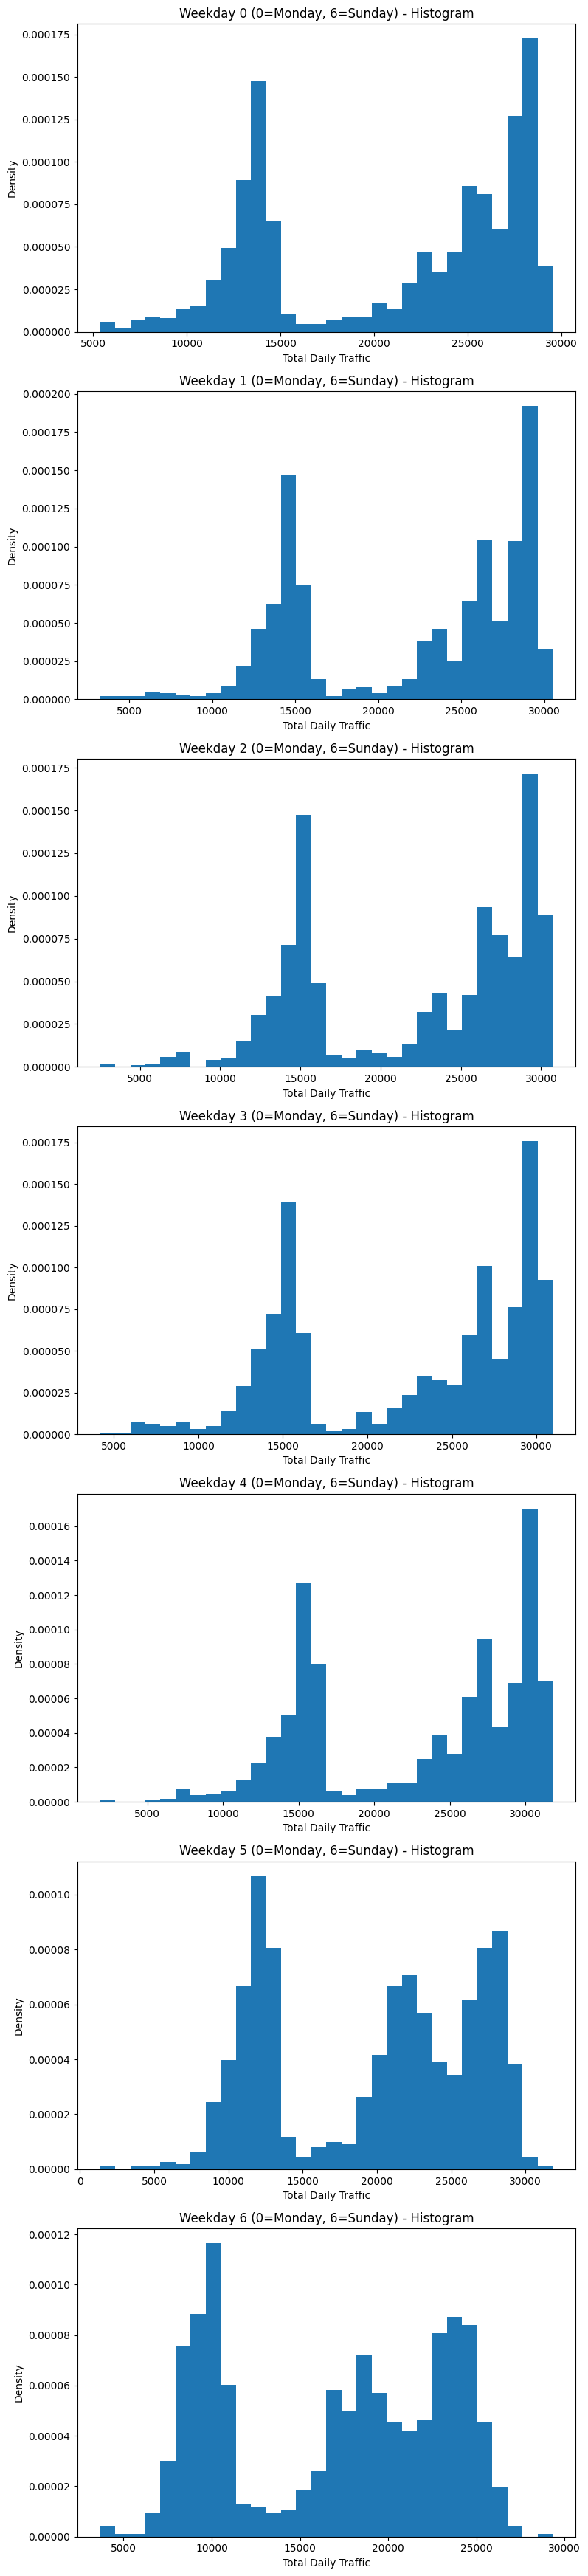

In [56]:
# Plotting distributions for each day of the week using 'Weekday_X' columns
plt.figure(figsize=(15, 35))
for i in range(7):
    
    # Filtering data for each weekday
    weekday_data = train_set[train_set[f'Weekday_{i}'] == 1]['TotalDailyTraffic']
    weekday_data = weekday_data.dropna()

    # Creating subplot for histogram 
    ax_hist = plt.subplot(7, 2, 2*i+1)
    ax_hist.hist(weekday_data, bins=30, density=True)
    ax_hist.set_title(f'Weekday {i} (0=Monday, 6=Sunday) - Histogram')
    ax_hist.set_xlabel('Total Daily Traffic')
    ax_hist.set_ylabel('Density')

plt.tight_layout()
plt.show()

We still observe the same distribution with high values around the edges. This makes it hard to impute. Taking the median here would distort the distribution. Hence, we will drop the NaN rows in the TotalDailyTraffic column.

In [57]:
#drop NaNs
train_set.dropna(subset=['TotalDailyTraffic'], inplace=True)
test_set.dropna(subset=['TotalDailyTraffic'], inplace=True)
validation_set.dropna(subset=['TotalDailyTraffic'], inplace=True)



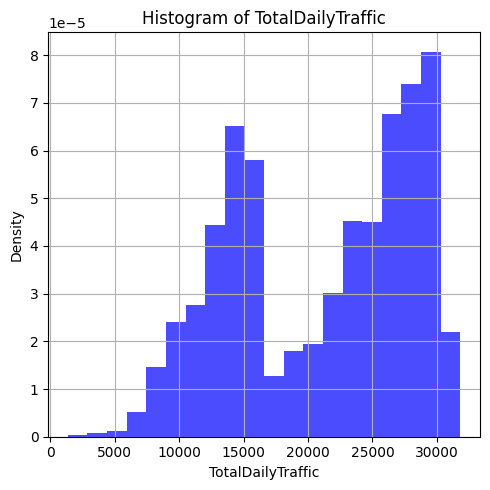

In [58]:
#Now let's check how it looks like after the imputation

plt.figure(figsize=(5, 5))
plt.hist(train_set['TotalDailyTraffic'], bins=20, color='blue', alpha=0.7, density=True)
plt.title('Histogram of TotalDailyTraffic')
plt.xlabel('TotalDailyTraffic')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

Due to the high values around the edges, it might be helpful for the model if we transform the TotalDailyTraffic column by applying the logarithm.

In [59]:
train_set['TotalDailyTraffic_log'] = np.log(train_set['TotalDailyTraffic'])
test_set['TotalDailyTraffic_log'] = np.log(test_set['TotalDailyTraffic'])
validation_set['TotalDailyTraffic_log'] = np.log(validation_set['TotalDailyTraffic'])

**Filling the rest of the columns' NaN Values**

For those with small or no outliers, we will use the mean to impute. These are the following columns: "O3", "O3_max_h1", "O3_nb_h1>120", "T", "T_max_h1", "WD", "Hr"

For those with a a lot and strong outliers, we will use the median, as it is more robust to outliers. These are the following columns: 'NO', 'NO2', 'NOx', 'PM10', 'RainDur', 'p' ,'WVv', 'WVs'.

Furthermore, we will apply log transformation to those features with outliers. This will help the model later.

In [61]:
# Define the columns with little/no outliers and those with many
columns_little_outliers = ["O3", "O3_max_h1", "O3_nb_h1>120", "T", "T_max_h1", "WD", "Hr", 'StrGlo']
columns_many_outliers = ['NO', 'NO2', 'NOx', 'PM10', 'RainDur', 'p', 'WVv', 'WVs', 'PM2.5', 'PN', 'CO', 'SO2']
columns_with_outliers = ['NO', 'NO2', 'NOx', 'PM10', 'RainDur', 'p', 'WVv', "O3", "O3_max_h1", "O3_nb_h1>120", "WD", 'WVs', 'PM2.5', 'PN', 'CO', 'SO2']

# Impute NaNs in columns with little outliers using the mean
mean_values_train = train_set[columns_little_outliers].mean()
train_set[columns_little_outliers] = train_set[columns_little_outliers].fillna(mean_values_train)
test_set[columns_little_outliers] = test_set[columns_little_outliers].fillna(mean_values_train)
validation_set[columns_little_outliers] = validation_set[columns_little_outliers].fillna(mean_values_train)

# Impute NaNs in columns with a lot of outliers using the median
median_values_train = train_set[columns_many_outliers].median()
train_set[columns_many_outliers] = train_set[columns_many_outliers].fillna(median_values_train)
test_set[columns_many_outliers] = test_set[columns_many_outliers].fillna(median_values_train)
validation_set[columns_many_outliers] = validation_set[columns_many_outliers].fillna(median_values_train)

# Function to apply log transformation if no negative values are present
def safe_log_transform(dataset, columns):
    for col in columns:
        if (dataset[col] > 0).all():  # Check if all values in the column are non-negative
            dataset[col] = np.log(dataset[col])  # Apply log1p transformation

# Apply the transformation to each dataset
safe_log_transform(train_set, columns_with_outliers)
safe_log_transform(test_set, columns_with_outliers)
safe_log_transform(validation_set, columns_with_outliers)


# Check if there are any NaN values left in 
nan_after_imputation_train = train_set.isna().sum() == 0
nan_after_imputation_test = test_set == 0
nan_after_imputation_validation = validation_set.isna().sum() == 0

# Output whether all values are True
print("All NaNs imputed in train_set:", all(nan_after_imputation_train))
print("All NaNs imputed in test_set:", all(nan_after_imputation_test))
print("All NaNs imputed in validation_test:", all(nan_after_imputation_validation))


All NaNs imputed in train_set: True
All NaNs imputed in test_set: True
All NaNs imputed in validation_test: True


From our analysis we know that NO2 has many outliers. Hence, NO2_tomorrow does too. 
We will thus apply log transformation to our target variable as well.

In [62]:
#Apply the function from above to our target variable
safe_log_transform(train_set, ['NO2_tomorrow'])
safe_log_transform(test_set, ['NO2_tomorrow'])
safe_log_transform(validation_set, ['NO2_tomorrow'])

### Feature Engineering: Reducing Multicollinearity

In order to mitigate potential issues related to multicollinearity in our regression model, we will apply a technique known as the 'dummy variable trap' to the categorical features representing seasons and weekdays. The dummy variable trap arises when there is high correlation among dummy variables, and it can adversely impact the performance of the regression model. Specifically, for the categorical feature 'Season,' we created dummy variables for each season. Now if three are false, the fourth one must be true. Hence, having all four seasons is actually redundant. Dropping this reduced multicollinearity. Same goes for the weekdays.

Further, we will plot a correlation matrix and then find features for which the collinearity is higher than a certain threshold. One of these two features will then be dropped. 

In [63]:
#Dummy Variable Trap
train_set.drop(columns=['Weekday_6', 'Season_4'], inplace=True)
test_set.drop(columns=['Weekday_6', 'Season_4'], inplace=True)
validation_set.drop(columns=['Weekday_6', 'Season_4'], inplace=True)

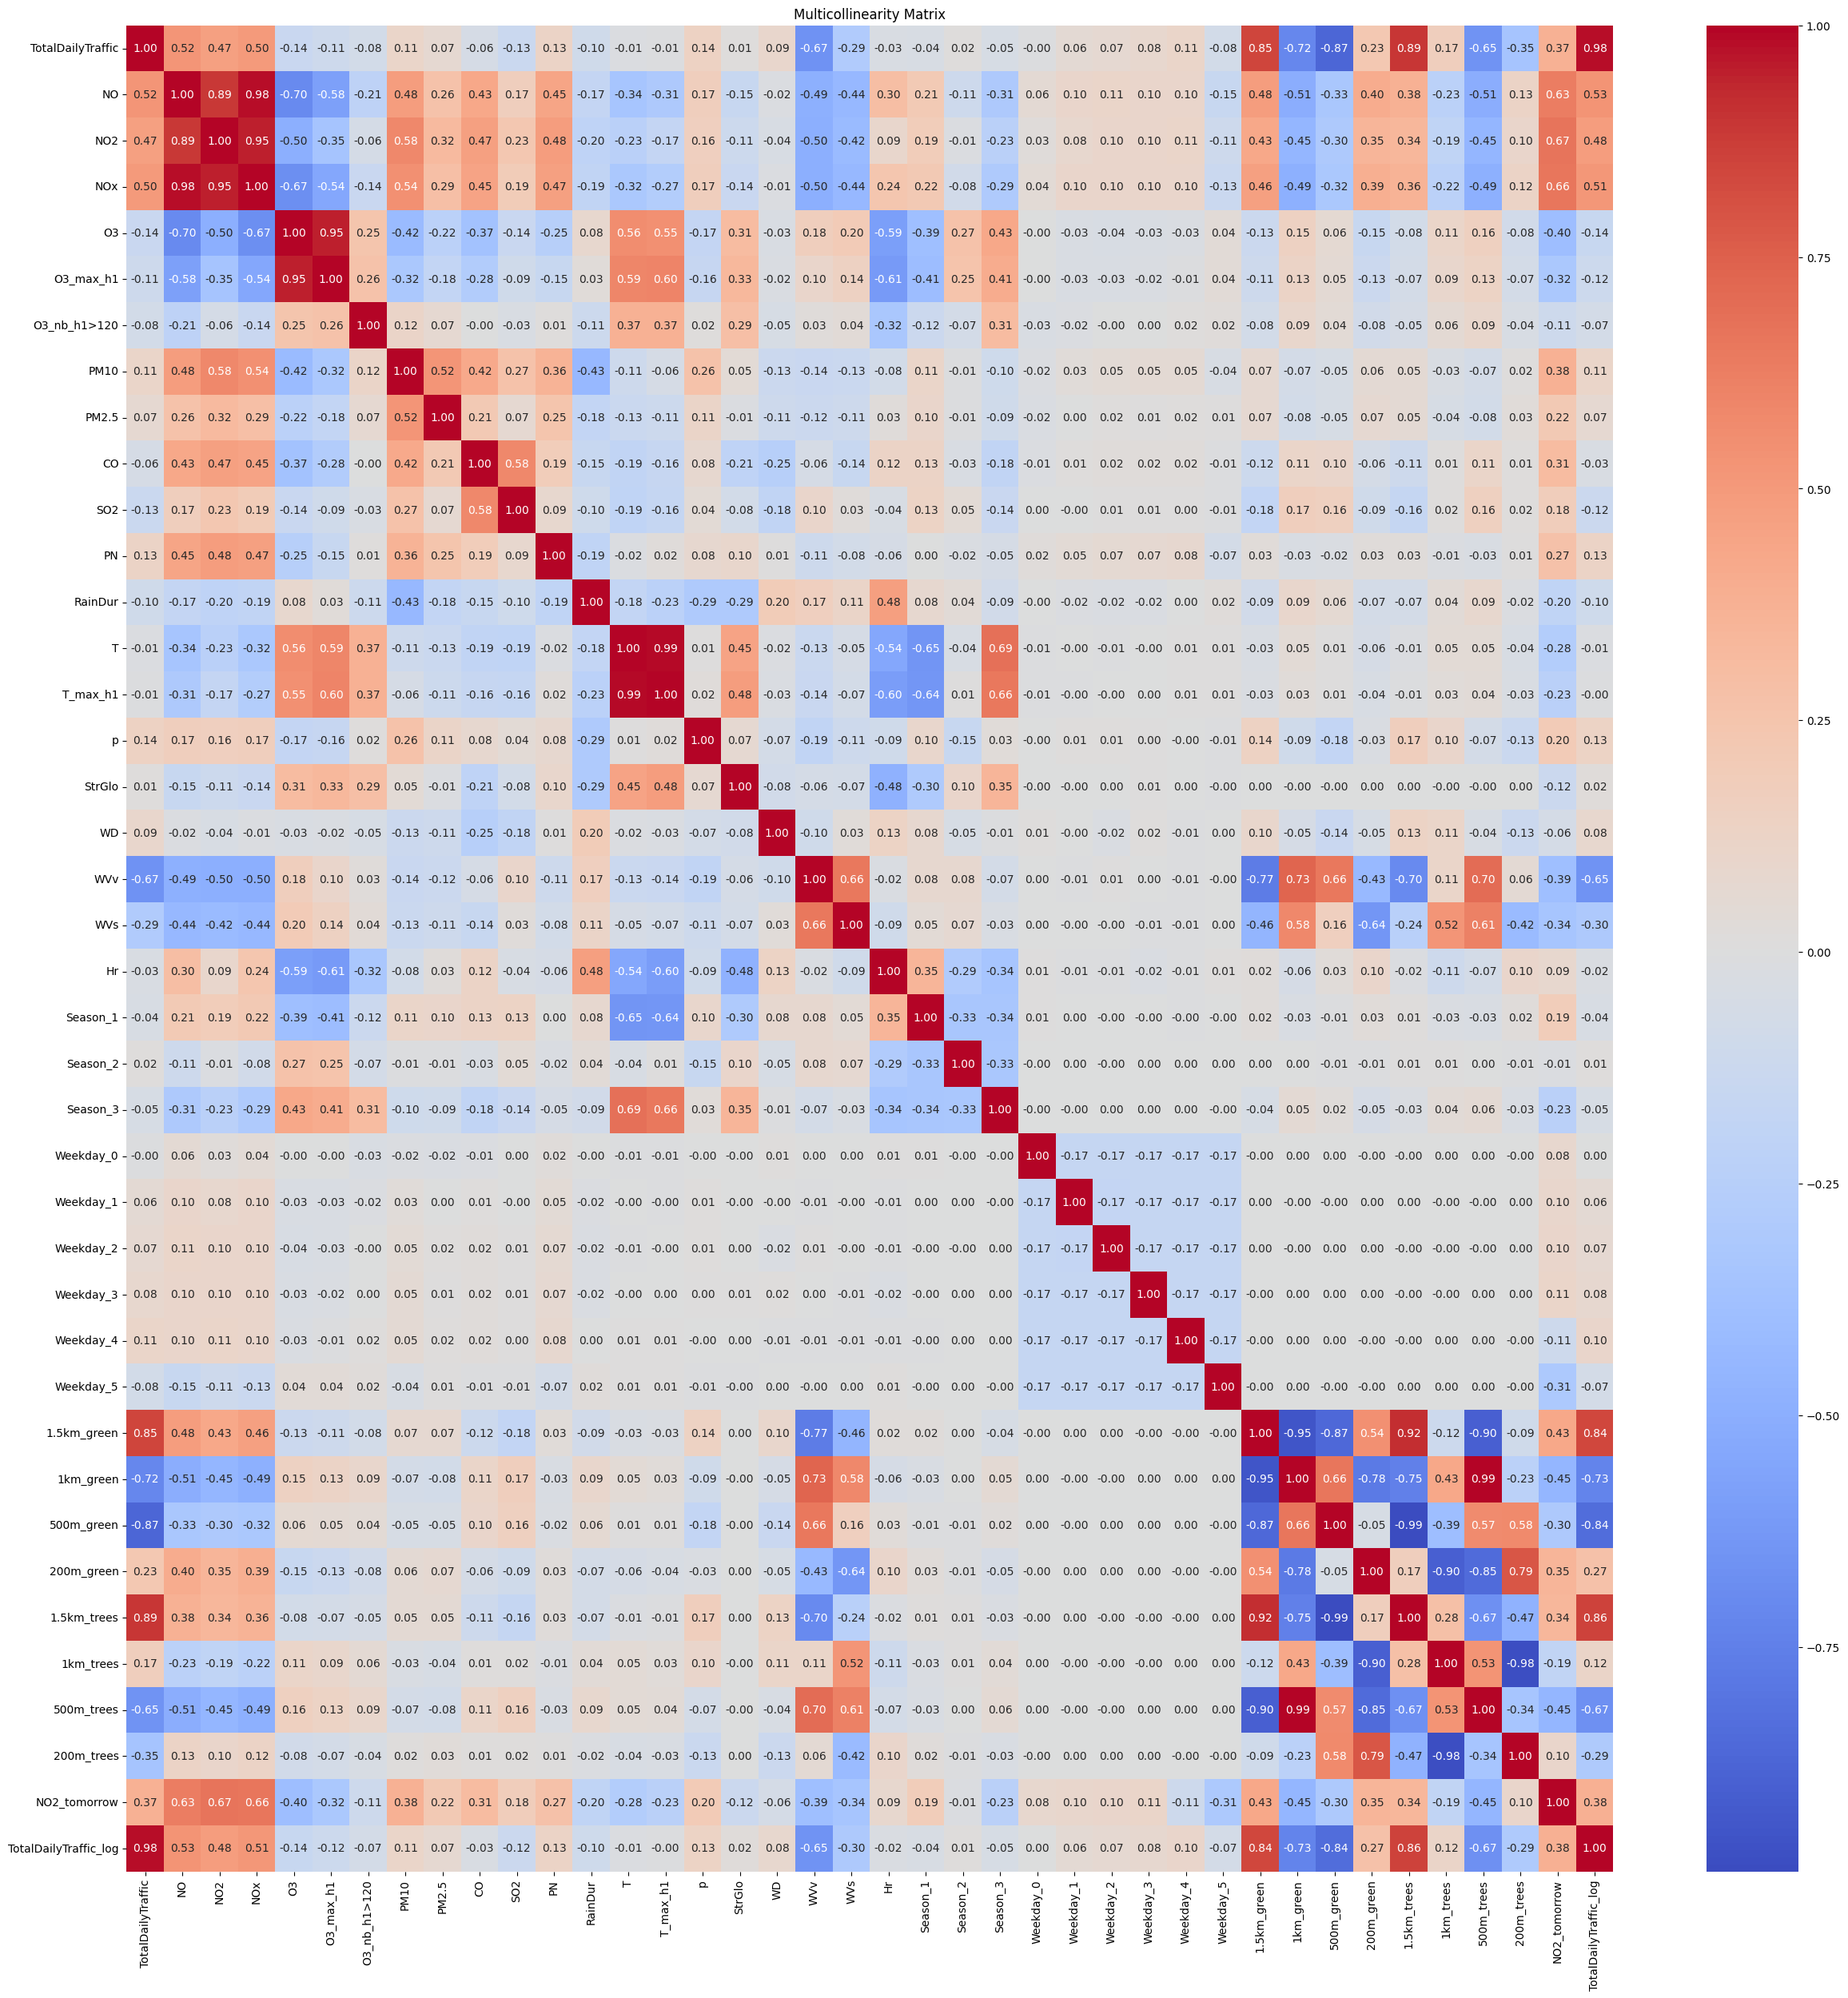

In [64]:
#Correlation Matrix
corr_matrix = train_set.drop(columns=['Datum', 'Street']).corr()

# Use a heatmap to visualize the correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Multicollinearity Matrix')
plt.show()

From the multicollinearity matrix we see that we have some features which are highly correlated. In order to improve the performance of our model, we will delete one of the two features, if the multicollinearity is higher than 0.9.

In [65]:
high_corr_var = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_var.add(colname)

# Remove the identified features
train_reduced = train_set.drop(columns=high_corr_var)
test_reduced = test_set.drop(columns=high_corr_var)
validation_reduced = validation_set.drop(columns=high_corr_var)

### Feature Engineering: Polynomials

We build some polynomial features to capture possible, non linear relationships.

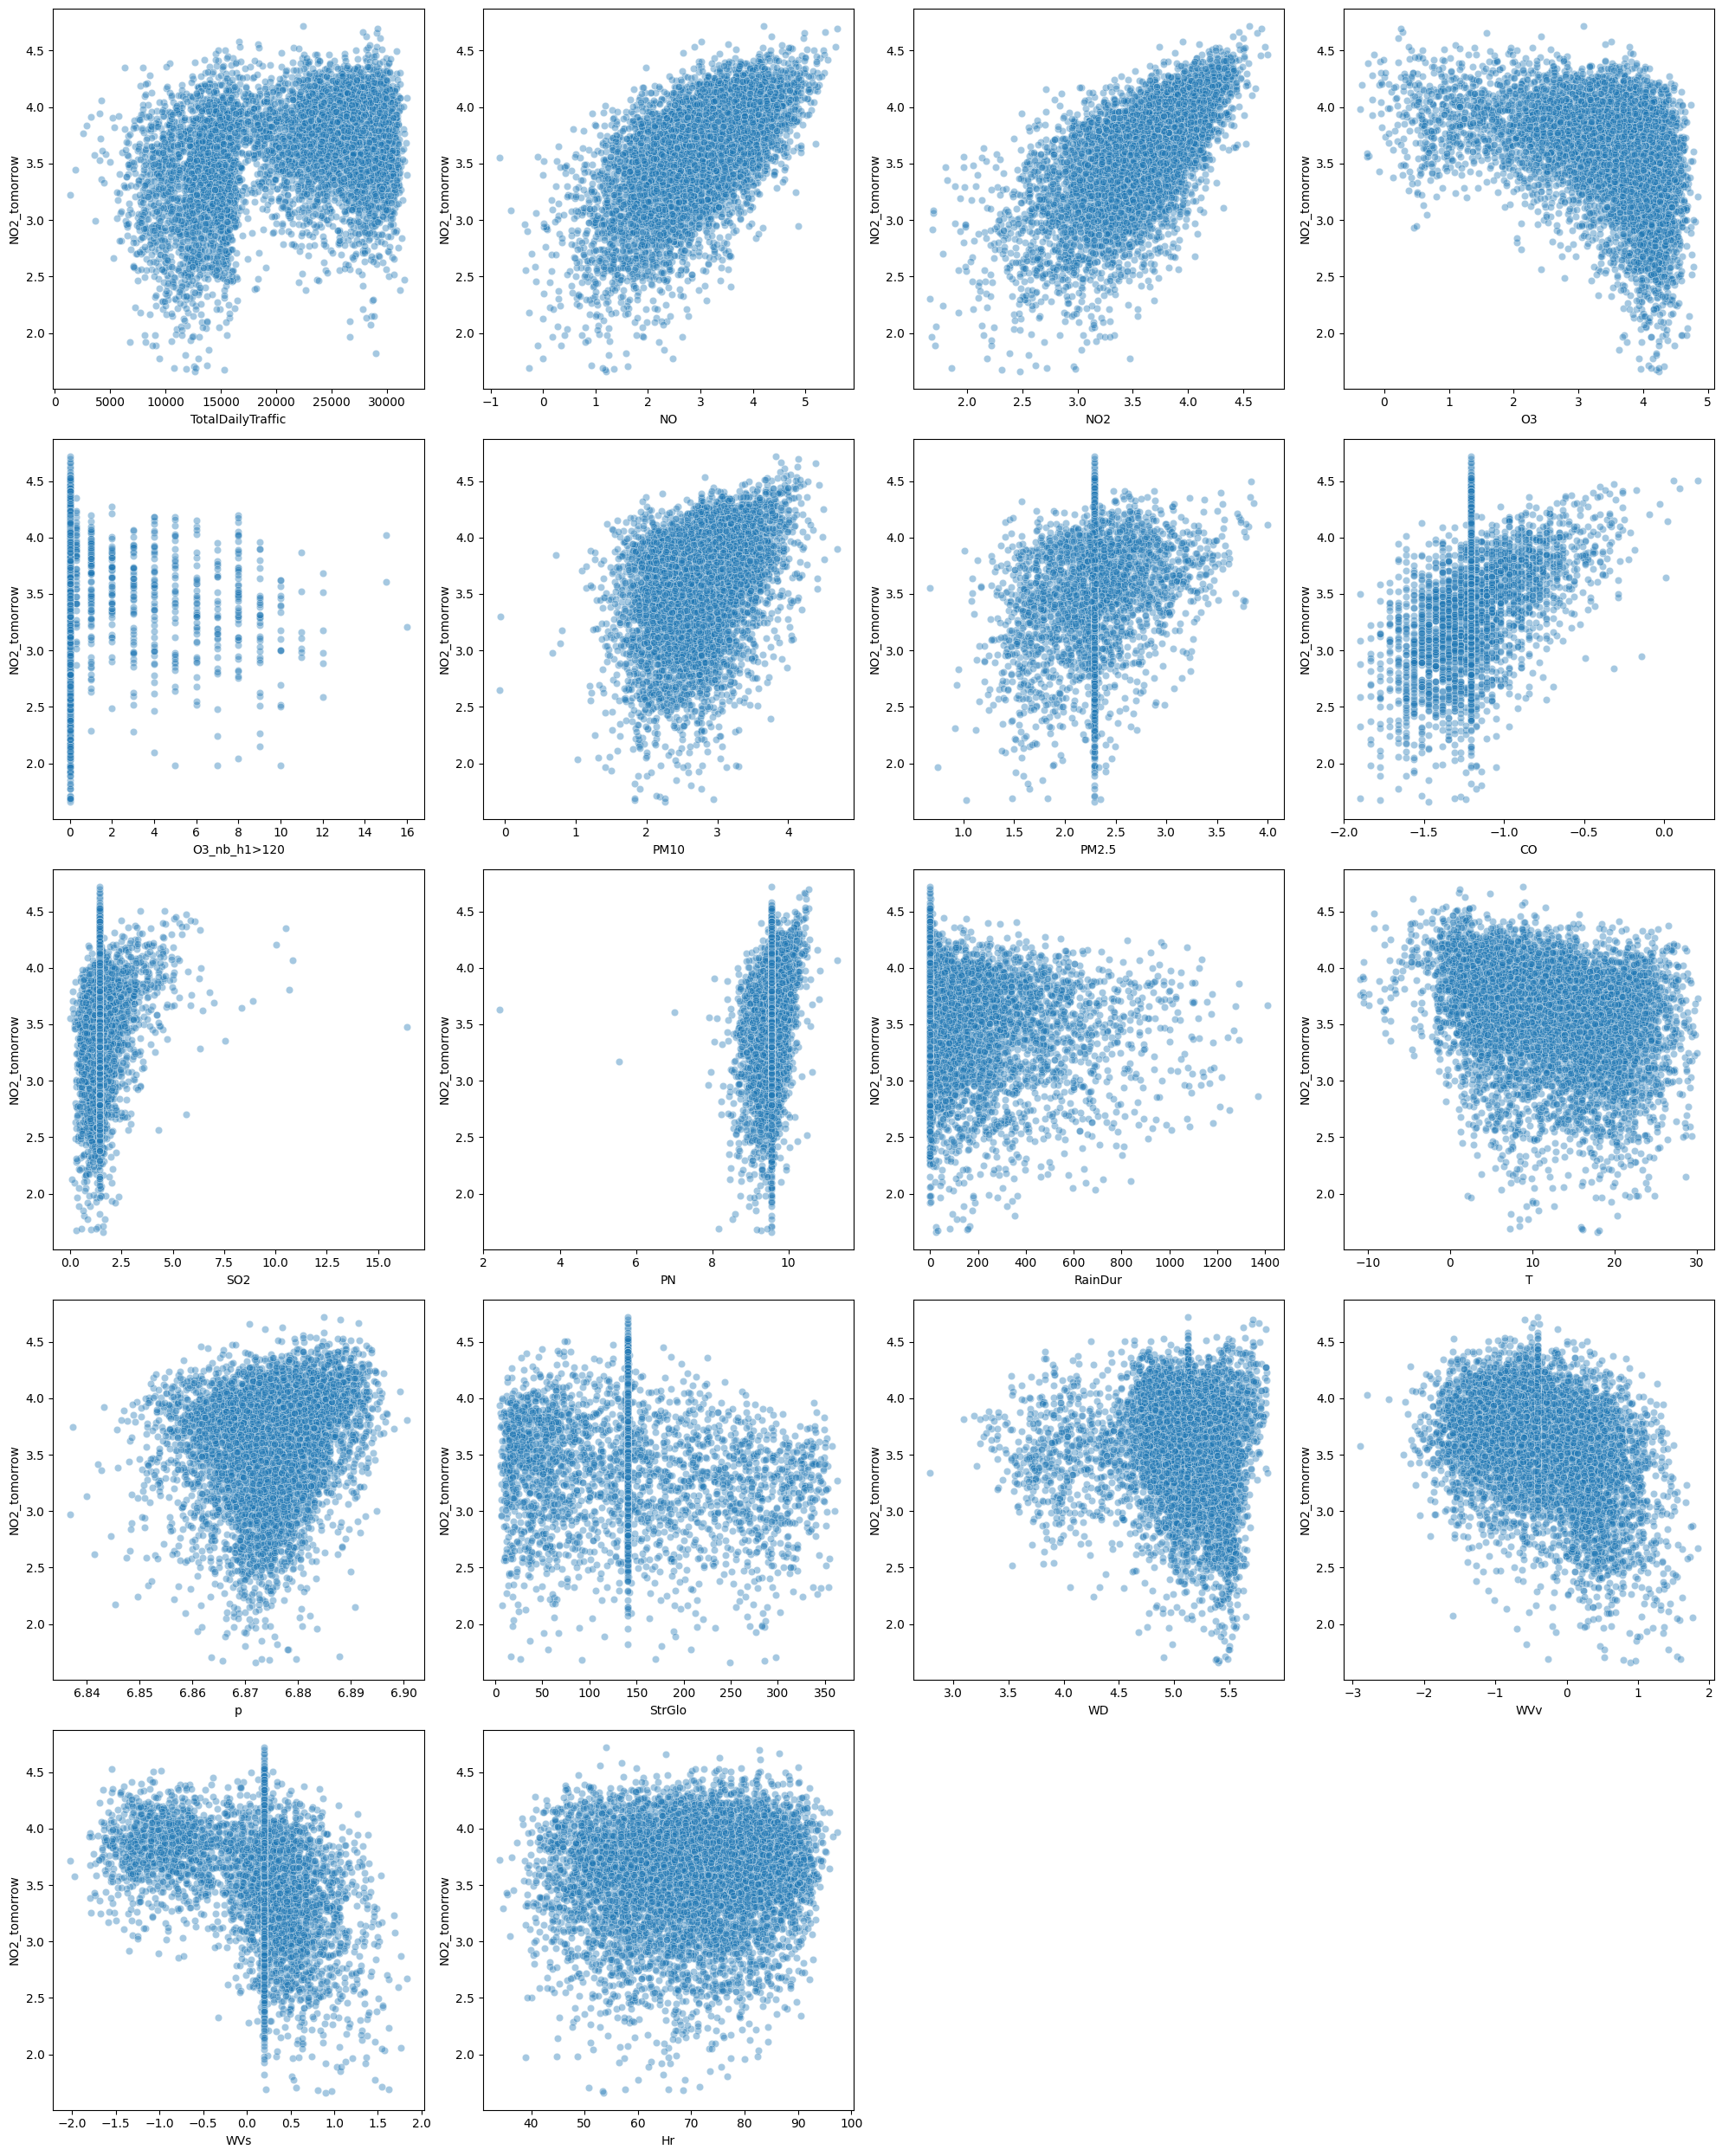

In [66]:
#Plot features to see the relationships

# Excluding non-numerical columns and the target variable itself
plot_columns = train_reduced.select_dtypes(include=['float64', 'int64']).columns.drop(['NO2_tomorrow'])

# Define the number of plots: 4 columns in each row
num_columns = 4
num_rows = len(plot_columns) // num_columns + (1 if len(plot_columns) % num_columns else 0)

# Create a figure with subplots
plt.figure(figsize=(20, 5 * num_rows))

# Plotting each feature against 'NO2_tomorrow'
for i, column in enumerate(plot_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.scatterplot(x=train_reduced[column], y=train_reduced['NO2_tomorrow'], alpha=0.4)
    plt.xlabel(column)
    plt.ylabel('NO2_tomorrow')

plt.tight_layout()
plt.show()


Our dataset reveals unclear linear relationships for most features with the target variable, except for NO2. To address this, we consider introducing polynomial features to capture potential non-linear patterns.

Regarding the columns with high percentage of missing values: We see that they seem to somewhat correlate with the target variable. Hence, it was the right decision not to drop these features entirely.

In [67]:
from sklearn.preprocessing import PolynomialFeatures

def create_complete_polynomial_features(train_set, validation_set, test_set, exclude_features, polydegree):
   
    # Selecting numerical features excluding the specified ones
    numerical_features = train_set.select_dtypes(include=['float64', 'int64']).columns
    selected_features = numerical_features.drop(exclude_features)

    # Extracting the selected features from the datasets
    X_train = train_set[selected_features]
    X_validation = validation_set[selected_features]
    X_test = test_set[selected_features]

    # Creating polynomial features up to the specified degree
    poly = PolynomialFeatures(degree=polydegree)
    X_train_poly = poly.fit_transform(X_train)
    X_validation_poly = poly.transform(X_validation)  # Using the same fit for the validation set
    X_test_poly = poly.transform(X_test)  # Using the same fit for the test set

    # Creating DataFrames for the polynomial features
    poly_feature_names = poly.get_feature_names_out(selected_features)
    X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=train_set.index)
    X_validation_poly_df = pd.DataFrame(X_validation_poly, columns=poly_feature_names, index=validation_set.index)
    X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=test_set.index)

    # Merging the polynomial features with the original dataset
    train_final = pd.concat([train_set.drop(selected_features, axis=1), X_train_poly_df], axis=1)
    validation_final = pd.concat([validation_set.drop(selected_features, axis=1), X_validation_poly_df], axis=1)
    test_final = pd.concat([test_set.drop(selected_features, axis=1), X_test_poly_df], axis=1)

    return train_final, validation_final, test_final


# For degree 2
train_reduced_poly_2, validation_reduced_poly_2, test_reduced_poly_2 = create_complete_polynomial_features(train_reduced, validation_reduced, test_reduced, ['NO2', 'NO2_tomorrow'], 2)
train_poly_2, validation_poly_2, test_poly_2 = create_complete_polynomial_features(train_set, validation_set, test_set, ['NO2', 'NO2_tomorrow'], 2)

# For degree 3
train_reduced_poly_3, validation_reduced_poly_3, test_reduced_poly_3 = create_complete_polynomial_features(train_reduced, validation_reduced, test_reduced, ['NO2', 'NO2_tomorrow'], 3)
train_poly_3, validation_poly_3, test_poly_3 = create_complete_polynomial_features(train_set, validation_set, test_set, ['NO2', 'NO2_tomorrow'], 3)



# Model Testing

In this section, we evaluate the predictive performance of our models using two distinct algorithms: Linear Regression and Random Forests. Each model brings its own set of strengths and characteristics to the task of predicting NO2 levels for our dataset.

## Linear Regression 

Our process is as follows:

1. For all of the different dataset pairs, we will first standardize them using the MinMaxScaler. This helps reducing the effect of outliers on our model by scaling everything to be between 0 and 1. Thereby, in order to avoid future leakage, we fit the standardizer only on the training set and then use this to standardize the validation and test set.

2. Then we apply Lasso to select the most important features. Having to many features needlessly overcomplicates a mdoel and can lead to overfitting. Lasso reduces the coefficients of less important features to zero. This is especially important as we have several polynomials. Lasso will do the selection for us. In order to find the optimal parameter, we utilise the LassoCV. 

3. After we have selected our features, we will use linear regression to build our model and then evaluate it based on MSE, R2 and adjusted R2. 

Thois process is the result of going back and forth with different techniques. We have also tried using StandardScaler, or Ridge regression instead of linear regression. However, the below model yielded the best results. 



In [68]:
# Define your dataset pairs including validation sets
dataset_pairs = [
    ('train_set', train_set, 'validation_set', validation_set, 'test_set', test_set),
    ('train_reduced', train_reduced, 'validation_reduced', validation_reduced, 'test_reduced', test_reduced),
    ('train_poly_2', train_poly_2, 'validation_poly_2', validation_poly_2, 'test_poly_2', test_poly_2),
    ('train_reduced_poly_2', train_reduced_poly_2, 'validation_reduced_poly_2', validation_reduced_poly_2, 'test_reduced_poly_2', test_reduced_poly_2),
    ('train_poly_3', train_poly_3, 'validation_poly_3', validation_poly_3, 'test_poly_3', test_poly_3),
    ('train_reduced_poly_3', train_reduced_poly_3, 'validation_reduced_poly_3', validation_reduced_poly_3, 'test_reduced_poly_3', test_reduced_poly_3),
]

# Perform standardization
scaler = MinMaxScaler()

# Variables to store results
results_dict = {'MSE': {}, 'R2 Score': {}, 'Adjusted R2 Score': {}}

for train_dataset_name, train_dataset, validation_dataset_name, validation_dataset, test_dataset_name, test_dataset in dataset_pairs:
    
    # Preprocess datasets
    X_train = train_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
    y_train = train_dataset['NO2_tomorrow']
    X_validation = validation_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
    y_validation = validation_dataset['NO2_tomorrow']
    X_test = test_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
    y_test = test_dataset['NO2_tomorrow']

    # Standardization
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)
    X_test_scaled = scaler.transform(X_test)
 

    # Lasso for feature selection
    lasso = LassoCV(cv=5, random_state=0, max_iter=100000, tol=0.01).fit(X_train_scaled, y_train)
    important_features = lasso.coef_ != 0
    X_train_important = X_train_scaled[:, important_features]
    X_validation_important = X_validation_scaled[:, important_features]
    X_test_important = X_test_scaled[:, important_features]

    # Linear regression on selected features
    linreg = LinearRegression().fit(X_train_important, y_train)

    # Predict on training, validation, and test sets
    y_pred_train = linreg.predict(X_train_important)
    y_pred_validation = linreg.predict(X_validation_important)
    y_pred_test = linreg.predict(X_test_important)
    
    #Evaluate on validation Set
    mse_validation = mean_squared_error(y_validation, y_pred_validation)
    r2_validation = r2_score(y_validation, y_pred_validation)
    # Calculate adjusted R2 for validation set
    n_validation = X_validation_important.shape[0]
    k_validation = X_validation_important.shape[1]
    adjusted_r2_validation = 1 - ((1 - r2_validation) * (n_validation - 1) / (n_validation - k_validation - 1))

    print(f"\nDataset Pair: {train_dataset_name} / {validation_dataset_name}")
    print(f"Validation Set - MSE: {mse_validation:.2f}, R2 Score: {r2_validation:.2f}, Adjusted R2 Score: {adjusted_r2_validation:.2f}")

    # Final evaluation on the test set
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Calculate adjusted R2 for test set
    n_test = X_test_important.shape[0]
    k_test = X_test_important.shape[1]
    adjusted_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test))


    print(f"Test Set - Test MSE: {mse_test:.2f}, Test R2 Score: {r2_test:.2f}, Adjusted R2 Score: {adjusted_r2_test:.2f}\n")

    # Store results in the dictionary
    results_dict['MSE'][f"{train_dataset_name} / {test_dataset_name}"] = mse_test
    results_dict['R2 Score'][f"{train_dataset_name} / {test_dataset_name}"] = r2_test
    results_dict['Adjusted R2 Score'][f"{train_dataset_name} / {test_dataset_name}"] = adjusted_r2_test



Dataset Pair: train_set / validation_set
Validation Set - MSE: 0.09, R2 Score: 0.58, Adjusted R2 Score: 0.58
Test Set - Test MSE: 0.10, Test R2 Score: 0.56, Adjusted R2 Score: 0.56


Dataset Pair: train_reduced / validation_reduced
Validation Set - MSE: 0.09, R2 Score: 0.59, Adjusted R2 Score: 0.58
Test Set - Test MSE: 0.10, Test R2 Score: 0.57, Adjusted R2 Score: 0.57


Dataset Pair: train_poly_2 / validation_poly_2
Validation Set - MSE: 0.09, R2 Score: 0.57, Adjusted R2 Score: 0.56
Test Set - Test MSE: 0.11, Test R2 Score: 0.54, Adjusted R2 Score: 0.54


Dataset Pair: train_reduced_poly_2 / validation_reduced_poly_2
Validation Set - MSE: 0.10, R2 Score: 0.56, Adjusted R2 Score: 0.55
Test Set - Test MSE: 0.11, Test R2 Score: 0.53, Adjusted R2 Score: 0.53


Dataset Pair: train_poly_3 / validation_poly_3
Validation Set - MSE: 0.09, R2 Score: 0.57, Adjusted R2 Score: 0.55
Test Set - Test MSE: 0.11, Test R2 Score: 0.51, Adjusted R2 Score: 0.51


Dataset Pair: train_reduced_poly_3 / valid

We observe that there is not much gain in performance for higher polynomials. Hence, we will focus on the simplest model. 
What we also observe is that the difference in accuracy between the validation and test set is very small. Hence, our model seems to generalize rather well.


In order to put our model into context, we will compare it to a naive model. Below, we predict tomorrows NO2 concentration simply by todays value.

In [69]:
# Define a function for the naive model
def naive_model(X):
    # The naive model predicts tomorrow's NO2 based on today's NO2
    return X['NO2'].values

# Variables to store results
naive_results_dict = {'MSE': {}, 'R2 Score': {}, 'Adjusted R2 Score': {}}

# Preprocess training data
X_train = train_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_train = train_dataset['NO2_tomorrow']

# Predict on training set
y_pred_train_naive = naive_model(X_train[['NO2']])
mse_train_naive = mean_squared_error(y_train, y_pred_train_naive)
r2_train_naive = r2_score(y_train, y_pred_train_naive)

# Calculate adjusted R2 for training set
n_train_naive = X_train[['NO2']].shape[0]
k_train_naive = 1  # Number of predictors, which is 1 for the naive model
adjusted_r2_train_naive = 1 - ((1 - r2_train_naive) * (n_train_naive - 1) / (n_train_naive - k_train_naive - 1))

# Preprocess validation data
X_validation = validation_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_validation = validation_dataset['NO2_tomorrow']

# Predict on validation set
y_pred_validation_naive = naive_model(X_validation[['NO2']])
mse_validation_naive = mean_squared_error(y_validation, y_pred_validation_naive)
r2_validation_naive = r2_score(y_validation, y_pred_validation_naive)

# Calculate adjusted R2 for validation set
n_validation_naive = X_validation[['NO2']].shape[0]
k_validation_naive = 1  # Number of predictors, which is 1 for the naive model
adjusted_r2_validation_naive = 1 - ((1 - r2_validation_naive) * (n_validation_naive - 1) / (n_validation_naive - k_validation_naive - 1))

# Preprocess test data
X_test = test_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_test = test_dataset['NO2_tomorrow']

# Predict on test set
y_pred_test_naive = naive_model(X_test[['NO2']])
mse_test_naive = mean_squared_error(y_test, y_pred_test_naive)
r2_test_naive = r2_score(y_test, y_pred_test_naive)

# Calculate adjusted R2 for test set
n_test_naive = X_test[['NO2']].shape[0]
k_test_naive = 1  # Number of predictors, which is 1 for the naive model
adjusted_r2_test_naive = 1 - ((1 - r2_test_naive) * (n_test_naive - 1) / (n_test_naive - k_test_naive - 1))

print(f"\nDataset Pair: {train_dataset_name} / {validation_dataset_name} / {test_dataset_name}")
print(f"Train Set - Naive Model MSE: {mse_train_naive:.2f}, Naive Model R2 Score: {r2_train_naive:.2f}, Adjusted R2 Score: {adjusted_r2_train_naive:.2f}")
print(f"Validation Set - Naive Model MSE: {mse_validation_naive:.2f}, Naive Model R2 Score: {r2_validation_naive:.2f}, Adjusted R2 Score: {adjusted_r2_validation_naive:.2f}")
print(f"Test Set - Naive Model MSE: {mse_test_naive:.2f}, Naive Model R2 Score: {r2_test_naive:.2f}, Adjusted R2 Score: {adjusted_r2_test_naive:.2f}\n")

# Store results in the dictionary
naive_results_dict['MSE'][f"{train_dataset_name} / {validation_dataset_name} / {test_dataset_name}"] = mse_test_naive
naive_results_dict['R2 Score'][f"{train_dataset_name} / {validation_dataset_name} / {test_dataset_name}"] = r2_test_naive
naive_results_dict['Adjusted R2 Score'][f"{train_dataset_name} / {validation_dataset_name} / {test_dataset_name}"] = adjusted_r2_test_naive



Dataset Pair: train_reduced_poly_3 / validation_reduced_poly_3 / test_reduced_poly_3
Train Set - Naive Model MSE: 0.13, Naive Model R2 Score: 0.34, Adjusted R2 Score: 0.34
Validation Set - Naive Model MSE: 0.13, Naive Model R2 Score: 0.40, Adjusted R2 Score: 0.40
Test Set - Naive Model MSE: 0.13, Naive Model R2 Score: 0.44, Adjusted R2 Score: 0.44



We see that our linear regression model outperforms the naive model by 14% in R2 score. The MSE is also significantly better.

In order to understand our model better, we will plot the results below. Further we will calculate the MSE on the original scale (before log transformation).

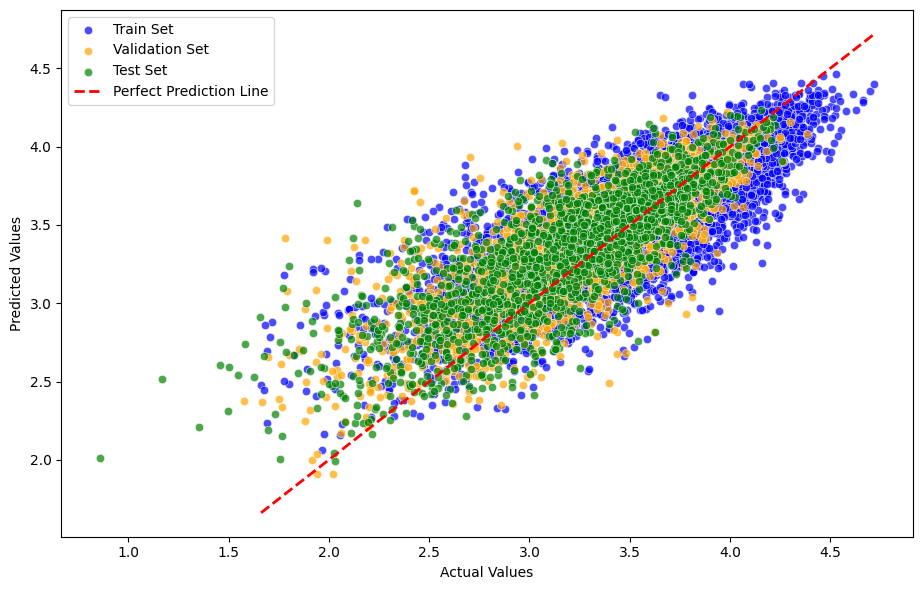

Linear Regression Model
Train MSE (Original Scale): 87.09, Train R2 Score: 0.64
Validation MSE (Original Scale): 60.20, Validation R2 Score: 0.58
Test MSE (Original Scale): 55.60, Test R2 Score: 0.56


In [70]:
# Plotting the results for the linear regression model on regular datasets
plt.figure(figsize=(18, 6))
scaler = MinMaxScaler()

# Preprocess the datasets
X_train = train_reduced.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_train = train_reduced['NO2_tomorrow']
X_validation = validation_reduced.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_validation = validation_reduced['NO2_tomorrow']
X_test = test_reduced.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_test = test_reduced['NO2_tomorrow']

# Standardization
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

# Lasso for feature selection
lasso = LassoCV(cv=5, random_state=0, max_iter=100000, tol=0.01).fit(X_train_scaled, y_train)
important_features = lasso.coef_ != 0
X_train_important = X_train_scaled[:, important_features]
X_validation_important = X_validation_scaled[:, important_features]
X_test_important = X_test_scaled[:, important_features]

# Linear regression on selected features
linreg = LinearRegression().fit(X_train_important, y_train)

# Predict on training, validation, and test sets
y_pred_train = linreg.predict(X_train_important)
y_pred_validation = linreg.predict(X_validation_important)
y_pred_test = linreg.predict(X_test_important)

# Calculate MSE and R2 Score
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Undo the logarithm transformation
y_pred_train_original = np.exp(y_pred_train)
y_pred_validation_original = np.exp(y_pred_validation)
y_pred_test_original = np.exp(y_pred_test)

# Calculate the MSE on the original scale
mse_train_original = mean_squared_error(np.exp(y_train), y_pred_train_original)
mse_validation_original = mean_squared_error(np.exp(y_validation), y_pred_validation_original)
mse_test_original = mean_squared_error(np.exp(y_test), y_pred_test_original)

# Subplot for the ridge regression model
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_pred_train, color='blue', alpha=0.7, label='Train Set')
sns.scatterplot(x=y_validation, y=y_pred_validation, color='orange', alpha=0.7, label='Validation Set')
sns.scatterplot(x=y_test, y=y_pred_test, color='green', alpha=0.7, label='Test Set')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction Line')
#plt.title(f"Linear Regression Model\nTrain MSE: {mse_train:.2f}, Train R2 Score: {r2_train:.2f}\nValidation MSE: {mse_validation:.2f}, Validation R2 Score: {r2_validation:.2f}\nTest MSE: {mse_test:.2f}, Test R2 Score: {r2_test:.2f}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

plt.tight_layout()
plt.show()

title_str = f"Linear Regression Model\nTrain MSE (Original Scale): {mse_train_original:.2f}, Train R2 Score: {r2_train:.2f}\nValidation MSE (Original Scale): {mse_validation_original:.2f}, Validation R2 Score: {r2_validation:.2f}\nTest MSE (Original Scale): {mse_test_original:.2f}, Test R2 Score: {r2_test:.2f}"
print(title_str)


### Random Forest

Here it makes no difference whether we use polynomials or not. so we will just use our regular train set

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Dropping non-numeric and irrelevant columns
X_train = train_set.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_train = train_set['NO2_tomorrow']

X_validation = validation_set.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_validation = validation_set['NO2_tomorrow']

X_test = test_set.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_test = test_set['NO2_tomorrow']

# Building the Random Forest Regressor with a smaller Cross-Validation grid to optimize hyperparameters
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Evaluating the optimized model on the validation set
y_pred_val = best_rf.predict(X_validation)
mse_val = mean_squared_error(y_validation, y_pred_val)
r2_val = r2_score(y_validation, y_pred_val)

print(f"Validation Set - MSE: {mse_val}, R2 Score: {r2_val}, Best Parameters: {best_params}")

# Evaluating the optimized model on the test set
y_pred_test = best_rf.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test Set - MSE: {mse_test}, R2 Score: {r2_test}")




Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  11.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  12.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  12.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  25.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  13.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  14.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  14.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  28.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  28.4s
[CV] END ma

KeyboardInterrupt: 